# Project: Linear Regression on King's County Home Sales Data Set

My goal of this project is to determine which features of the data set most influence the price of a home from two perspectives:
- the buyer
- the seller

Sub-goals or questions I will attempt to answer at the tail-end of this work include:
1. Do structural features or location, as a whole, influence home sale price more?

## Approach

My high-level approach is to build the most robust, most predictive model (with highest *Coefficient of Determination*, $R^2$) on the largest set of statistically significant features (those with low *p-value*) as possible.

To that end, I adopt standard *model validation* techniques, with some added caveats.

### High $R^2$ is not enough!
We are not only interested simply in the the model's *Coefficient of Determination*, $R^2$, but we also want a feel  of the confidence of that measure.

**A "high" $R^2$ (say, $R^2 \ge 0.7$) could be artificially inflated with a high degree of *multicolinearity*, for example**.

### Overfitting must be minimized
As part of our procedure when building linear regression models, we minimize over-fitting by utilizing the `stepwise_selection` routine, which, as its name suggests, selects features (or drops them) to be used in the model based on the range of their *p-value*.

A *low* p-value indicates that the feature is statistically significant in a linear relationship to its *target*.  In our case, we accept features with $0 \le p\_value < 0.05$.

This contributes to the confidence in the resulting $R^2$ from the get-go since we know that features which are not statistically significant will not appear in the model.

### Data Bias must be minimized as much as possible
I opted to use *sci-kit learn's* `train_test_split` api to split the data set into test/train partitions at the standard ratio of $0.70$/$0.30$.  After features are stepwise-selected, the model is fit to the *training* partition.  

I opted to not use *k-folds* for building the test/train partitions: a single pass of `train_test_split` is good enough in this case.

### Model validation
Confidence in the computed *Coefficient of Determination*, $R^2$, itself must be measured since not all $R^2$'s are created equal!

I use the standard measure for that purpose: compute the **Mean Squared Error (MSE)** of the model on both the train and test partitions and compute the *delta*.  **A *delta* between MSE's of train/test predictions close to zero indicates high confidence in $R^2$**.

Additionally, as it relates to *multicolinearity*, I compute the **Variance Inflation Factor (VIF)** in the target of each feature.  Evidently, **a $VIF > 10$ indicates that a given feature has a high degree of *multicolinearity***.  I then summarize the aggregate to derive a ratio of "good" ($VIF \le 10$) vs "bad" ($VIF > 10$) features.  If this ratio is high (e.g. 70% or more), then our confidence in our measure of the *Coefficient of Determination* ($R^2$) increases.

### Conditions for success - i.e. whether a linear regression model is "good" or "bad"
Given the following conditions, we have a "GOOD" model:
1. $R^2 > .70$
2. $|MSE(test) - MSE(train)| \approx 0$
3. $\frac{|\{feature \in \{selected features\}: VIF(feature) \le 10\}|}{|\{selected features\}|} > .75$ 

The first condition says that we want models that determine the target with 70% confidence.

The second condition says that the bias toward the data is virtuall non-existent.

The third condition says that less than 25% of our selected features are considered *colinear*.

### Toward Regression: Most important aspect is understanding the data!
To that end, I proceed according to the following steps:
1. Import all necessary libraries and the the data set
2. Cleaning the data set:
    1. Clean null values, if any
    2. Clean outlier values, if any
    3. Convert feature data types as necessary
3. EDA: Gain familiarity with the data set by building a preliminary linear regression model
    1. Explore distriubutions
    2. Explore colinearity
3. EDA: Scale, Normalize, Transform features in the data set as necessary
4. Run linear regression experiments to derive answers to the following questions:
    1. As a whole, do structural features or location influence home sale price more?
    2. If structural, which subset of features are the most influential?

## Step 1: Import Libraries and the Data Set

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import numpy as np
import scjpnlib.utils as scjpnutils
import scjpnlib.regression.api as scjpnregression
import datetime

%matplotlib inline

plt.style.use('ggplot')

scjpnregression.plot_edge = 4

In [2]:
# import the data set
kchd_df = pd.read_csv('kc_house_data.csv')

## Step 2: Exploratory Data Analysis and Data Set Cleaning

One of the single most important facets of understanding the data is inspecting its values or, more specifically, the ranges of values each feature has.  Most important in that is understand whether a given feature is quantitative or qualitative, or, more precisely whether a given feature is *continuous* or *categorical*.

But, having null values in the data set may present problems in this part of our understanding process.  So, our first step is to deal with null values.  Even non-null but unexpected anomalous data can present problems and these are known as "outliers".  We must identify when possible and deal with outliers as part of this process as well.

This process is collectively known as "cleaning the data set".
<br>
<br>


The `print_df_head` utility function simply allows us to print multiple Pandas DataDrames with "pretty" (HTML) formatting, using the Python `print` function.

We will use it throughout this notebook whenever we wish to display a DataFrame.

We use it to get now to our first look at the data set.

In [3]:
 scjpnutils.print_df_head(kchd_df)

We noticed right off the bat that there is a null (`NaN`) value in the very first row.

## Step 2.A: Cleaning Null Values

We officially begin our *EDA* phase by cleaning null values in the data set.

The `cols_with_null_vals` function provides a summary of all features in our data set that have null values.

In [4]:
kchd_cwnv_df = scjpnutils.cols_with_nulls(kchd_df)
display(HTML("<b>Features with null values:</b><br><br>"))
scjpnutils.print_df(kchd_cwnv_df)

We are working our way toward cleaning these null values.  As part of the process, after having identified which features need to be cleaned of null values, we must decide on a strategy for clearning this data.  One of the "Golden Rules" in Data Science is to avoid dropping observations from our data set at all costs and is only to be used as a last resort during the *EDA* phase.  So, we decide early that we will do absolutely no dropping of any observations containing null values whatsoever.  We opt to adopt a null-value *replacement* scheme.  But, we need some heuristic to decide target values which will replace nulls that makes sense.  Understanding the data better for each of these features should suggest an acceptable replacement heuristic.

To do this, we investigate the unique values of the above features, and whether those features are *continuous* or *categorical*.

###  Step 2.A: Cleaning Null Values: Using Unique Values (and Categorical "Classification") in Null-Value Replacement Guidance

Since *we do not wish to drop any observations containing null values* of **continuous** features and since *we do not wish to radically alter their distributions*, **we shall use some aggregate function which retains the existing central tendency of the *non-null* continuous values in our data set** - i.e. depending on the presence of outliers or not, in the case of continuous data, we opt to replace with the *median* or *mean* of the good values, respectively.

**We shall replace null values in categorical observations with some discrete value from the set of unique non-null categorical values**.  But which discrete value?  Well, this is where categorical classification comes in.  Thus, we must inspect the *meaning* of the categorical values in order to properly choose which value should replace a null value.

So, let's take a look that now.

**The first thing we need to do is determine which features *containing null-values* are categorical** (and which features are continuous).

The `categorical_probability` utiity function derives a probability that a given feature is categorical or not *based on the ratio of unique values to the total number of observations*.  If this ratio is very low, then it suffices to say that the probability is high that the feature is categorical.

And the `classify_as_categorical` utility function wraps the `categorical_probability` function to display all features with a "p_cat" greater than some threshold.

Let's use it now to help determine our replacement heuristic for the features that contain null-valued observations: **waterfront**, **view**, and **yr_renovated**.

In [5]:
p_cat = 0.0
kchd__nulls_with_cat_classification_df = scjpnutils.classify_as_categorical(kchd_df[kchd_cwnv_df['name']], p_cat)
display(HTML("<b>Features with null-valued observations, categorical probability classification:</b><br><br>".format(p_cat)))
scjpnutils.print_df(kchd__nulls_with_cat_classification_df)

As you can see, the probability that each of the above features is categorical is VERY HIGH!  This is consistent with the actual list of unique values for each (excluding null).

This gives an indication that we can use a *lteral-value replacement heuristic* when we clean this data.

We can see that:
- **waterfront** behaves as a *Boolean* value and that a null value can safely be replaced by 0.0
- **view** ranges from 0 to 4: here we must decide which of these values makes most sense to use as a replacement for null
    - 0 means no views
    - so that we do not disrupt the central tendency, we could use the median value, 2.0
    - on the other hand, we could be unintentionally "un-skewing" this feature if the original intent of a null value was meant to be treated equivalent to value 0.0 - according to the documentation, **view** represents whether or not the property "has been viewed" (but it is really a count of the number of views).
    - in order to counter-act undesired skewing of the data, we opt to treat null values as equivalent to value 0.0
- **yr_renovated** clearly uses 0.0 to indicate that a home has not been renovated; so we will adopt the heuristic to replace null with 0.0 in this case

Since we have decided on the heuristics for all features with null values, we can clean those features now.

Note that, on a preliminary basis, it appears **there are no continuous features with null values**.

The `clean_offending_values` utility function was written to facilitate cleaning the data based on a *text-based rule definition*.  It simply uses pandas to locate values that match a given condition - e.g. NaN values - and replaces them with the desired target value.  It is a convenience method for replacing with both literal values and "macro"-based (or computed) values - .e.g. the *mean* or *median* of all non-null values.

Replacement rules are defined according to the *Backus–Naur Form* given below:
- *numeric* replacement rules should be of the form:
    - `{<name_of_col>: \[(outlier_val_1, 'median'|'mean'|<numeric_replacement_value>), ((outlier_val_2, 'median'|'mean'|<numeric_replacement_value>)), ... , (outlier_val_n, 'median'|'mean'|<numeric_replacement_value>)\]}}`
    
Let's use it now to replace NaN values of the above features with their corresponding values.

In [6]:
# now use the above function to clean 'waterfront' and 'yr_renovated' using lteral-value replacement
scjpnutils.clean_offending_values(
    kchd_df
    , numeric_replacement_rules=
        {
            'waterfront': [(np.NaN, 0.0)]
            , 'view': [(np.NaN, 0.0)]
            , 'yr_renovated': [(np.NaN, 0.0)]
        }
    , friendly_name_of_df="King County House Sales DF"
)

*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'waterfront' column value replacement are: [(nan, 0.0)]
Looking for rows with 'waterfront' values [nan] ...
Rows with offending values occur at Int64Index([    0,    10,    23,    40,    55,    60,    62,    66,    87,
              105,
            ...
            21544, 21545, 21550, 21562, 21567, 21578, 21582, 21586, 21587,
            21595],
           dtype='int64', length=2376).
Replaced 2376 offending instances in column 'waterfront' with literal value 0.0

Rules for 'view' column value replacement are: [(nan, 0.0)]
Looking for rows with 'view' values [nan] ...
Rows with offending values occur at Int64Index([    7,   114,   129,   205,   487,   590,   938,  1313,  1364,
             1701,  2415,  2833,  3150,  3237,  4533,  4740,  5196,  5207,
             5393,  5494,  5585,  5746,  6391,  7103,  7269,  7563,  7686,
             7716,  8047,  8066,  8279,  8575,  9405,  9853, 10023, 10174,
            1033

Having dealt with features with null values, we can now turn our attention to identifying and handling any potential outlier values.

## Step 2.B: Unique values provide understanding of outlier values and general understanding of the data

Now that we've cleaned all null-values (replaced with non-null values that make sense), we can get some idea of whether a given feature has any outlier values by inspecting its list of unique values.  Without null values present, unique values give us a clear view of:
- some idea of whether a feature is *continuous* or *categorical*
- a feature's value range - this is particularly important for continuous (quantitative) features

We can leverage the `classify_as_categorical` utility function to help identify such outlier values as well as their value ranges.

If we spot any peculiar values we can then deal with them as necessary.

In [7]:
# Let's look for outliers
p_cat = 0.0
kchd_cat_classification_df = scjpnutils.classify_as_categorical(kchd_df[kchd_df.columns[1:]], p_cat, False)
display(HTML("<b>View of features from the context of their unique values:</b><br><br>".format(p_cat)))
scjpnutils.print_df(kchd_cat_classification_df[['name', 'dtype', 'n_unique', 'p_cat', 'unique_vals']].set_index('name'))

Based on the above, we do spot a few specific issues:

1. based on *unique_vals* of **bedrooms**, it has an *apparent* OUTLIER value: 33.
2. based on *unique_vals* and *dtype* of **sqft_basement**, it looks like it should be a *numeric* data type but it is of type `Object` (probably stored as text).
3. the *dtype* of **yr_built** and **yr_renovated** is `int64` and `float64`, respectively; since these features store the same kind of values (year), we will convert **yr_renovated** to `int64`.

Let's address **sqft_basement** first.

## Step 2.B: Deal with outlier values: Converting **sqft_basement** from `string` type to `float`

Before attempting to convert the data type of **sqft_basement** to `float`, we need to replace any potential non-numeric values.

Let's find those first.

In [8]:
unique_sqft_basement = kchd_cat_classification_df[kchd_cat_classification_df['name']=='sqft_basement']['unique_vals'].values[0]
non_numeric_sqft_basement_vals = []
for idx, sqft_basement in enumerate(unique_sqft_basement):
    s_val = sqft_basement.strip()
    val = None
    try:       
        val = float(s_val)
    except:
        non_numeric_sqft_basement_vals.append(sqft_basement)

display(HTML("<b>sqft_basement</b> contains the following non-numeric values that must be replaced: {}".format(non_numeric_sqft_basement_vals)))

We opt to replace outlier value '?' of the **sqft_basement** feature with '0.0'.  

But we must do this *before* we finally convert it from `str` to `float`.

In [9]:
scjpnutils.clean_offending_values(
    kchd_df
    , string_replacement_rules=
        {
            'sqft_basement': [('?', '0.0')]
        }
    , friendly_name_of_df="King County House Sales DF"
)

*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'sqft_basement' are: [('?', '0.0')]
Looking for rows with 'sqft_basement' values in ['?'] ...
Rows with offending values occur at Int64Index([    6,    18,    42,    79,   112,   115,   217,   309,   384,
              508,
            ...
            21236, 21248, 21356, 21357, 21365, 21442, 21447, 21473, 21519,
            21581],
           dtype='int64', length=454).
Replaced 454 offending instances in column 'sqft_basement' with literal value '0.0'

*** CLEANING VALUES of King County House Sales DF: END ***


We can now convert **sqft_basement** to type `float`:

In [10]:
kchd_df['sqft_basement']=kchd_df['sqft_basement'].astype('float64')

### Step 2.B: Deal with outlier values: Handling **bedrooms** outliers

We make use of the `kchd_cat_classification_df` dataframe to examine potential outliers.

Looking at the **bedrooms** feature, we have the following:

In [11]:
kchd_cat_classification_df[kchd_cat_classification_df['name']=='bedrooms']

name  index  dtype  n_unique   p_cat  \
2  bedrooms      2  int64        12  0.9994   

                               unique_vals  
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 33]

Here, we see that there are home(s) that supposedly have 33 bedrooms.  Really?  I don't think so but let's try to justify this mathematically.

Let's examine the observations in our data set with **bedrooms** $== 33$.

In [12]:
outlier_rooms = 33
kchd_with_outlier_rooms_df = kchd_df[kchd_df['bedrooms']==outlier_rooms]
kchd_with_outlier_rooms_df

id       date     price  bedrooms  bathrooms  sqft_living  \
15856  2402100895  6/25/2014  640000.0        33       1.75         1620   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
15856      6000     1.0         0.0   0.0  ...      7        1040   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
15856          580.0      1947           0.0    98103  47.6878 -122.331   

       sqft_living15  sqft_lot15  
15856           1330        4700  

[1 rows x 21 columns]

First of all, we see that there is only a single observsation with **bedrooms** $== 33$.  This is truly the definition of an outlier. Is it worth it to take the time necessary to clean a single outlier?  Probably not but we do so for the sake of demonstration anyway.

We see that the value of **sqft_living** is only 1620.

Let's compute the average square footage per room and compare its value to the average square footage per room of the entire data set, excluding this possible outlier observation, with **bedrooms**==33.

In [13]:
outlier_rms_avg_sqft_per_room = kchd_with_outlier_rooms_df['sqft_living']/outlier_rooms
outlier_rms_avg_sqft_per_room[outlier_rms_avg_sqft_per_room.index]

15856    49.090909
Name: sqft_living, dtype: float64

We see that, for this outlier, the average square footage per room is about 49 ft.$^2$.  That means, on average, each room is 7 ft. x 7 ft in this property with 33 bedrooms?!?!  Is this likely?  This is highly unlikely but let's compare it to the average square footage per room of the rest of the data set, excluding this possible outlier observation with **bedrooms**==33.

Average square footage per room of the rest of the data set is:

In [14]:
avg_sqft_per_room_excluding_apparent_outlier = kchd_df['sqft_living'].sum()/kchd_df[kchd_df['bedrooms'].isin([outlier_rooms])==False]['bedrooms'].sum()
avg_sqft_per_room_excluding_apparent_outlier

617.0000686643413

We see that our outlier average square footage per room differs *drastically* from the average for the data set.  So we will impute the average of the data set (excluding this outlier observation) to arrive at a reasonable value replacement value for **bedrooms** of the outlier observation.  

Note:

    So far this has been a fair amount of work done to clean only a single observation but, again, this process demonstrates the potential importance in the general case.

The formula for this is 
$$imputed\_outlier\_bedrooms = \frac{outlier\_sqft\_living}{avg\_sqft\_per\_room\_excluding\_apparent\_outlier}$$ 

... and the value that we will impute in this case is computed as follows:

In [15]:
imputed_outlier_bedrooms = kchd_with_outlier_rooms_df['sqft_living']/avg_sqft_per_room_excluding_apparent_outlier
imputed_outlier_bedrooms = imputed_outlier_bedrooms.values[0]
imputed_outlier_bedrooms

2.62560748738151

Not so fast!  You'll notice that this is a real-valued result.  But does it make sense to have fractional bedrooms?  No it doesn't, not really.

Our work with this outlier is not yet done.

We need to match this imputed real-valued value with its "closest neighbor" in the range of observed *unique* (integer) values of **bedrooms**.  

We will call this set the "permissible values of bedrooms":

In [16]:
unique_bedrooms = sorted(list(kchd_df['bedrooms'].unique()))
unique_bedrooms.remove(outlier_rooms)
unique_bedrooms = np.array(unique_bedrooms)
print("Permissible values of bedrooms is: {}".format(unique_bedrooms))

Permissible values of bedrooms is: [ 1  2  3  4  5  6  7  8  9 10 11]


The following code accomplishes this:

In [17]:
idx_closest_br = -1
min_dist = -1
for idx, br in enumerate(unique_bedrooms):
    d = abs(imputed_outlier_bedrooms - br)
    if min_dist == -1:
        min_dist = d
        idx_closest_br = idx
    elif d < min_dist:
        min_dist = d
        idx_closest_br = idx

print("The closest permissible bedroom value to computed real-value {}, from {}, is {}, occuring at index {}.".format(imputed_outlier_bedrooms, unique_bedrooms, unique_bedrooms[idx_closest_br], idx_closest_br))
imputed_outlier_bedrooms = unique_bedrooms[idx_closest_br]

The closest permissible bedroom value to computed real-value 2.62560748738151, from [ 1  2  3  4  5  6  7  8  9 10 11], is 3, occuring at index 2.


Now we impute this value in the data set for all observations with the **bedrooms** outlier value, 33.

In [18]:
kchd_df.loc[kchd_with_outlier_rooms_df.index, 'bedrooms'] = imputed_outlier_bedrooms

## Step 2.C: Convert feature data types as necessary
We noticed in step 2.B that the *dtype* of **yr_built** and **yr_renovated** is `int64` and `float64`, respectively; since these features store the same kind of values (year), we need to convert **yr_renovated** to `int64`.  This is just a straightforward numerical type conversion.  Note that in converting from `float` to `int` any existing fractional year components will be lost.  But that is okay since we will not be making use of that data - the fractional part (if it exists) of **yr_renovated** - anyway.

In [19]:
kchd_df['yr_renovated']=kchd_df['yr_renovated'].astype('int64')

## Step 2: Finalize Data Cleaning

And with that, we have our final, cleaned data set.

Note that we will drop the **id** and **date** features:
1. **id** will not contribute whatsoever to linear regression
2. if **date** DOES contribute it will likely be due to other factors outside of this data set - e.g. the stock market, the local economy, unemployment rates, etc; so we just drop it from the start to remove any external influence from our model

The only thing left to do is store the results as an immutable basis, upon which all other manipulations will be based.  Note that this basis will not truly be immutable, but we will treat it as such.  That, if we find that we require any further manipulations to the data set, those manipulations will be done on a copy of this one, leaving the original, cleaned data set intact.

In [20]:
kchd_cleaned_df = kchd_df.drop(['id', 'date'], axis=1)

## Step 3: EDA through a Preliminary Linear Regression Model: Getting to Know the Features and Data

We now want to get a feel for how the feature set performs in a linear regression model without *scaling*, *normalization*, or *log-transformation*.

Note that **an integral component in building *every* linear regression model is invoking the `stepwise_selection` method** authored by David Dale, provided in [this](https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm) post.  This method includes a feature in (or drops from) the model based on its *p_value*.

Feature selection method: <function stepwise_selection at 0x1c1a6809d8>
stepwise_selection: Add  waterfront                     with p-value 0.0


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


stepwise_selection: Add  sqft_living                    with p-value 0.0
stepwise_selection: Add  grade                          with p-value 0.0
stepwise_selection: Add  lat                            with p-value 0.0
stepwise_selection: Add  yr_built                       with p-value 0.0
stepwise_selection: Add  view                           with p-value 1.758e-147
stepwise_selection: Add  bedrooms                       with p-value 3.86294e-53
stepwise_selection: Add  bathrooms                      with p-value 1.92687e-51
stepwise_selection: Add  zipcode                        with p-value 3.15121e-42
stepwise_selection: Add  long                           with p-value 4.16508e-55
stepwise_selection: Add  condition                      with p-value 9.11738e-20
stepwise_selection: Add  sqft_above                     with p-value 1.07784e-21
stepwise_selection: Add  yr_renovated                   with p-value 1.7494e-08
stepwise_selection: Add  sqft_living15                  with p

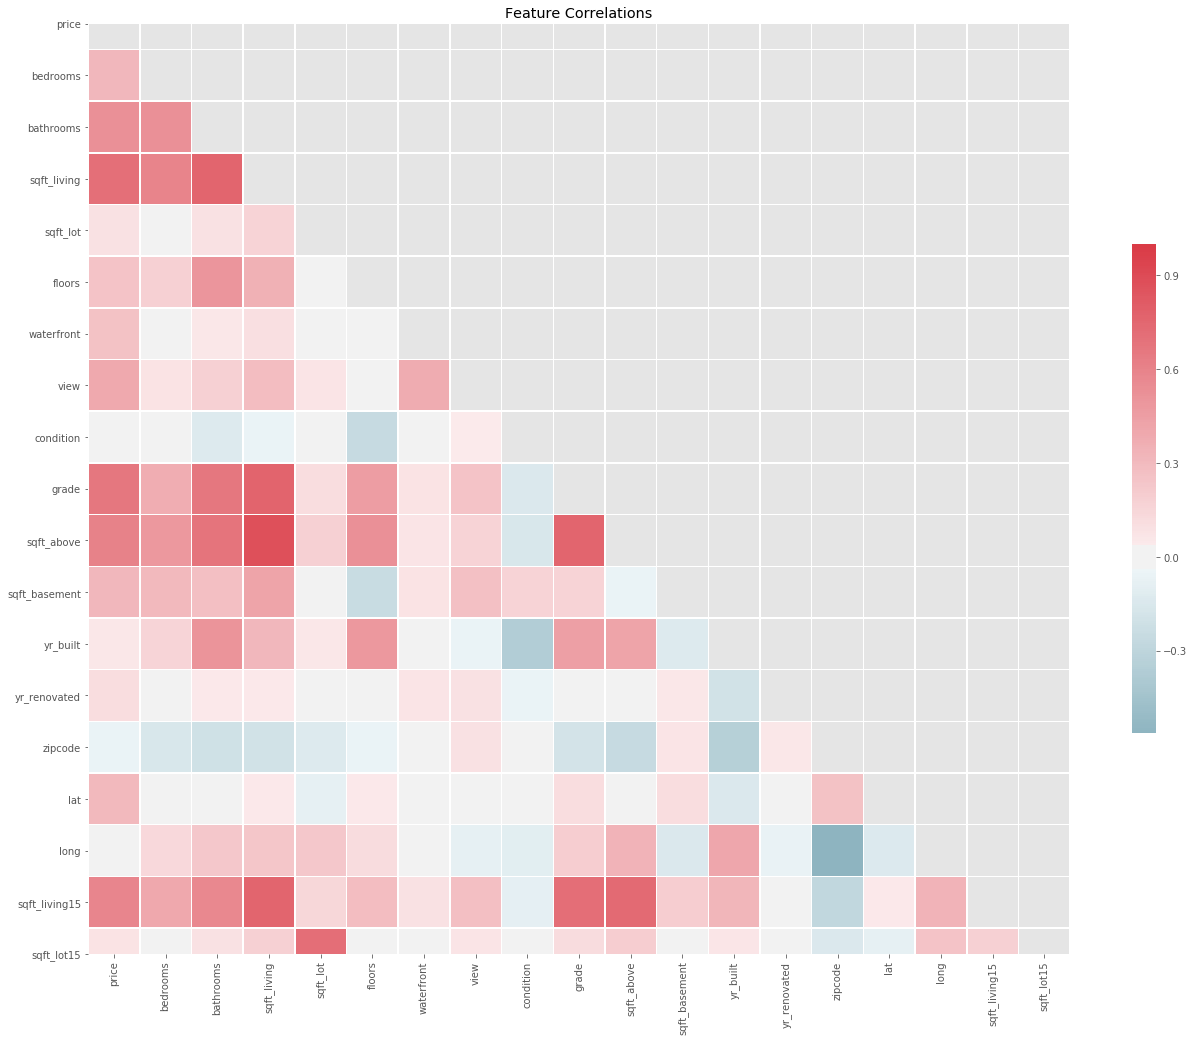

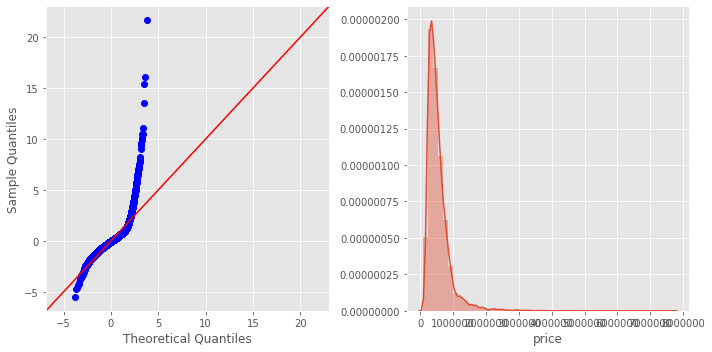

In [21]:
target = 'price'
tr = 0.30 # we want standard .70/30 traning-to-test ratio split
mv_r_sq_th = .50  # i.e. we want more than 50% Coefficient of Determination
mv_mse_delta_th = 1000 #???
mv_bad_vif_ratio_th = 0.30

(
    sel_features
    , their_pvals
    , X_train
    , X_test
    , y_train
    , y_test
    , train_mse
    , test_mse, model
) = scjpnregression.lin_reg_model_from_auto_selected_features(
    kchd_cleaned_df
    , target
    , tr=tr
    , title="Preliminary Linear Regression Model:"
)

(model_fit_results, good_vif_features, bad_vif_features) = scjpnregression.model_fit_summary(
    kchd_cleaned_df
    , sel_features
    , their_pvals
    , target
    , model
    , tr
    , train_mse
    , test_mse
    , mv_r_sq_th
    , mv_mse_delta_th
    , mv_bad_vif_ratio_th
)

### Step 3: EDA through a Preliminary Linear Regression Model: Analysis

In [22]:
display(HTML("$R^2 = {}$ is pretty good! But model validation fails two out three of our PASS conditions.".format(round(model_fit_results.rsquared, 3))))
display(HTML("Take a look at the difference in MSEs between our training and test partitions - note that we split based on a ${}$/${}$ ratio.".format(1-tr, tr)))
display(HTML("<b>The difference between MSE of our train/test partitions is a woeful ${}$</b>!".format(int(abs(train_mse-test_mse)))))

Note, in particular, that OLS reports that **"there are
strong multicollinearity or other numerical problems"** in the data set.

Our VIF summary states in more detail that most of our features are colinear.

$\Delta MSE$ is not good.  Let's face it: it's dreadful.  The meaning is that **this model does not reliably/accurately predict our target, *price*, in our test data set**.

The QQ-plot is also bad as it indicates an abundance of outliers by virtue of SEVERE tail deviation.

According to the [kurtosis](https://www.investopedia.com/terms/k/kurtosis.asp) article, kurtosis of this sort is [**leptokurtic**](https://www.investopedia.com/terms/l/leptokurtic.asp) and is highly undesirable since **there are occasional extreme outliers that cause 'concentrations' of observations** and detracts from stable predictability.  A leptokurtic distribution means that the **we can experience broader fluctuations in our target (e.g. three or more standard deviations from the mean) resulting in greater potential for extremely low or high price**. ("Kurtosis" and "Understanding Leptokurtic Distributions", 2019).

#### CONCLUSION:

**This is not a well-performing model**.  Not at all.

We MUST do some work to improve the performance of our preliminary linear regression model if we hope to predict sale price with confidence. 

#### What can we do to improve its performance?

The first thing we notice in the QQ-plot and the distribution plot of our target, **price**, is that it is heavily skewed - i.e. NOT normally distributed.

Again, before we conssider possibly dropping any features due to misbehavior, we shall scale and possibly transform our data set as a first measure.

But before we get into that, let's **give out target, *price*, a normal distribution by *log-transforming* it**.  And of course we will re-run regression to investigate the impact.  We noted already that the QQ-plot of residuals indicates the presence of outliers.  Scaling our target may mitigate this.

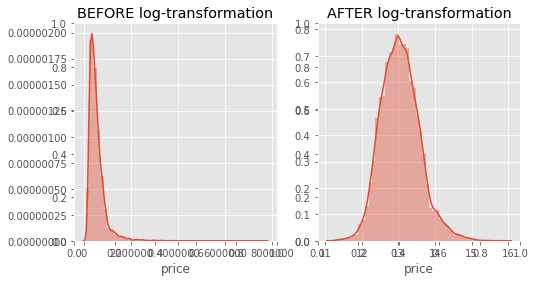

In [23]:
kchd_cleaned_with_log_transformed_target_df = kchd_cleaned_df.copy()
kchd_cleaned_with_log_transformed_target_df[target] = kchd_cleaned_with_log_transformed_target_df[target].map(lambda v: np.log(v))

scjpnregression.histograms_comparison(
    [
        kchd_cleaned_df[target]
        , kchd_cleaned_with_log_transformed_target_df[target]
    ]
    , [target, target]
    , ["BEFORE log-transformation", "AFTER log-transformation"]
)

Building a newly built linear regression model based on log-transformed target, **price**, in theory, should perform better than the last one.

### Step 3: EDA through a Preliminary Linear Regression Model, v. 2.0: after log-transforming target, *price*

Feature selection method: <function stepwise_selection at 0x1c1a6809d8>
stepwise_selection: Add  sqft_living                    with p-value 0.0


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


stepwise_selection: Add  grade                          with p-value 0.0
stepwise_selection: Add  lat                            with p-value 0.0
stepwise_selection: Add  view                           with p-value 0.0
stepwise_selection: Add  yr_built                       with p-value 0.0
stepwise_selection: Add  bathrooms                      with p-value 1.10449e-94
stepwise_selection: Add  sqft_living15                  with p-value 5.18085e-95
stepwise_selection: Add  condition                      with p-value 8.52738e-84
stepwise_selection: Add  waterfront                     with p-value 3.34106e-66
stepwise_selection: Add  floors                         with p-value 2.166e-59
stepwise_selection: Add  zipcode                        with p-value 1.48233e-37
stepwise_selection: Add  long                           with p-value 7.58078e-19
stepwise_selection: Add  sqft_lot                       with p-value 1.99337e-16
stepwise_selection: Add  yr_renovated                   with p

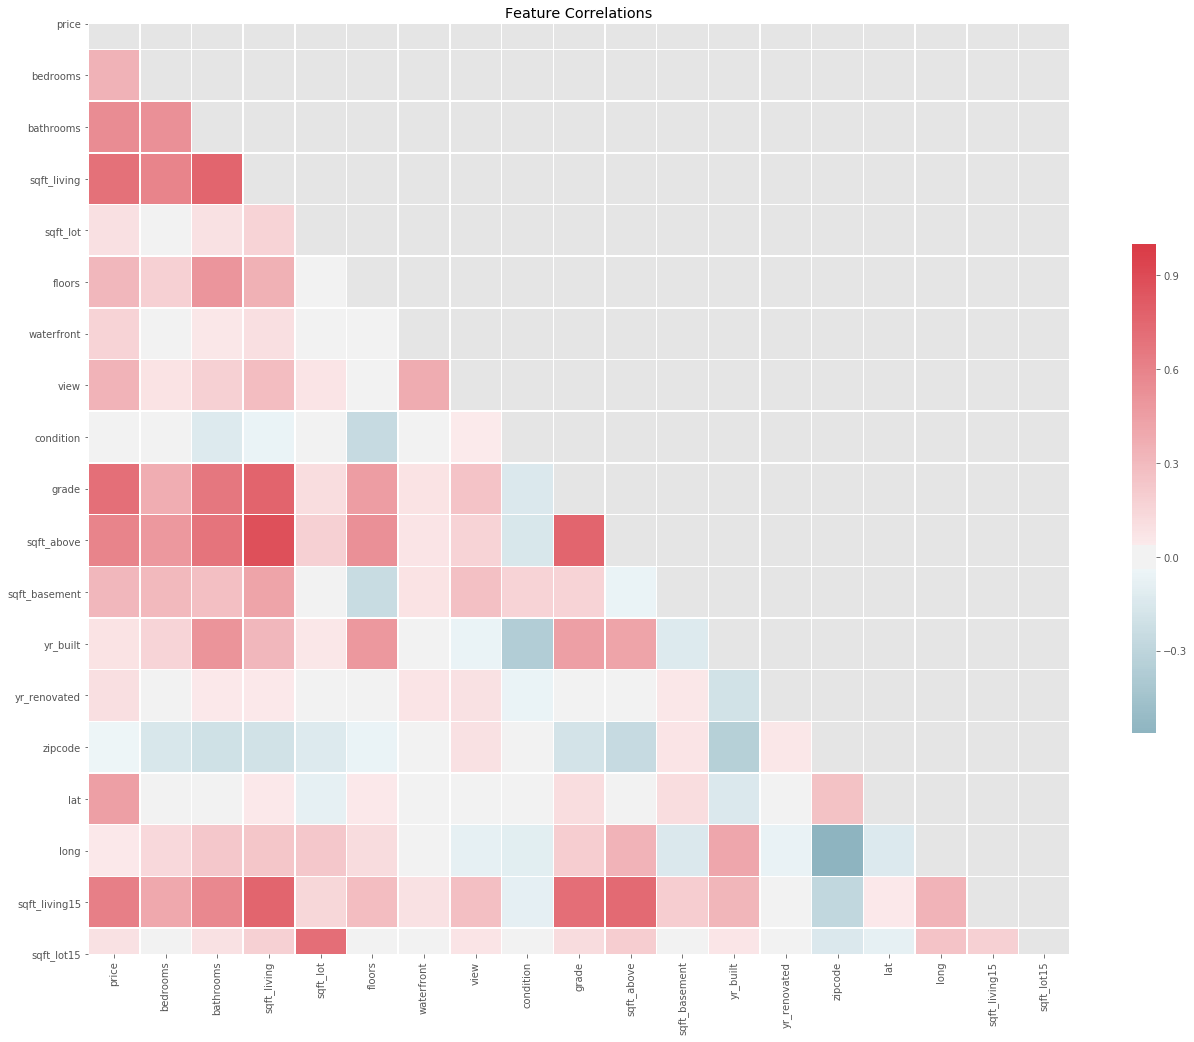

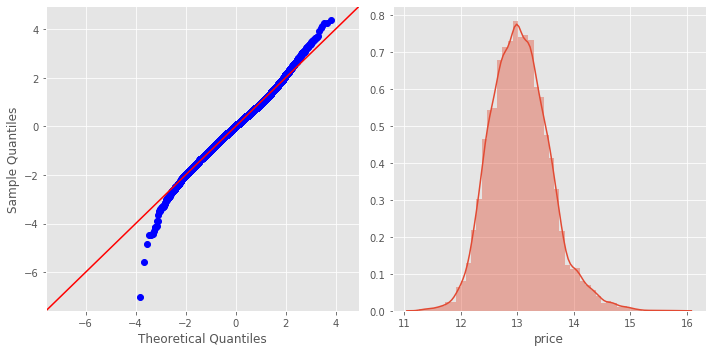

In [24]:
(
    sel_features
    , their_pvals
    , X_train
    , X_test
    , y_train
    , y_test
    , train_mse
    , test_mse, model
) = scjpnregression.lin_reg_model_from_auto_selected_features(
    kchd_cleaned_with_log_transformed_target_df
    , target
    , tr=tr
    , title="Preliminary Linear Regression Model, v 2.0: after log-transforming target, <i>price</i>"
)

(model_fit_results, good_vif_features, bad_vif_features) = scjpnregression.model_fit_summary(
    kchd_cleaned_with_log_transformed_target_df
    , sel_features
    , their_pvals
    , target
    , model
    , tr
    , train_mse
    , test_mse
    , mv_r_sq_th
    , mv_mse_delta_th
    , mv_bad_vif_ratio_th
)

### Step 3: EDA through a Preliminary Linear Regression Model, v. 2.0: Analysis

In [25]:
display(HTML("$R^2 = {}$ has improved quite a bit!".format(round(model_fit_results.rsquared, 3)))) #bad_vif_features
display(HTML("<b>Perhaps more impressive is the drop in $\Delta MSE$ to approximately ${}$</b>!".format(int(abs(train_mse-test_mse)))))
display(HTML("Multicolinearity is still an issue with {}% of our features being colinear (according to VIF analysis).".format(round((len(bad_vif_features)/len(sel_features))*100,2))))

Looking at the QQ-plot of residuals, the problem with outliers has been mitigated a bit by scaling our target, **price**.

The kurtosis manifested in this model appears to be a blend of [**leptokurtic**](https://www.investopedia.com/terms/l/leptokurtic.asp) and [**platykurtic**](https://www.investopedia.com/terms/p/platykurtic.asp) kurtosis.  

According to the [kurtosis](https://www.investopedia.com/terms/k/kurtosis.asp) article, **models manifesting [mesokurtic](https://www.investopedia.com/terms/m/mesokurtic.asp) distributions in the target are the most desirable since they will most stably offer accurate predictions**.  A model exhibiting a platykurtic distribution in the target is reliable (but not as much as one with  mesokurtic kurtosis) since, according to the article, **platykurtic target distributions are stable and predictable, in the sense that there will rarely (if ever) be extreme (outlier) observations of the target**.

As mentioned previously, leptokurtic distributions in the target are highly undesirable since there are occasional extreme outliers that cause 'concentrations' of observations and detract from stable predictability because we can experience broader fluctuations in our target (e.g. three or more standard deviations from the mean) resulting in greater potential for extremely low or high. ("Kurtosis" and "Understanding Leptokurtic Distributions", 2019).

We want a model with a kurtosis that is clearly platykurtic (acceptable) or mesokurtic (best case).

#### CONCLUSION:
Model Validation passed two out of three conditions.  Even though the model failed validation overall, we have VASTLY improved our model, just by *log-transforming* our target feature, **price**.

Nevertheless, **this is still not a well-performing model** (based on our assessment criteria).

Since this model still exhibits kurtosis that somewhat leptokurtic, we reject it.

#### What can we do to improve its performance?
Again, before we consider dropping features as a means to deal with multicolinearity, let's check for abnormal distributions of our features and log-transform them as necessary.  We will also *min-max scale* our target as well as all of our *continuous* features.  We will eventually get to the point where we officially *categorize* our *categorical* variables.  Doing all of this will eventually bring the ranges of our target and features (*continuous* and *categorical*) to \[0, 1\], which should improve our model even more.  Doing this should, in theory, address outliers even more.

Before we scale/transform our base set of predictors, let's have a look at the regression diagnostic and distribution plots of our predictors from the last model as a visual confirmation that we are on the right track with this line of thinking.

### Step 3: EDA through a Preliminary Linear Regression Model, v. 2.0: Regression Diagnostics

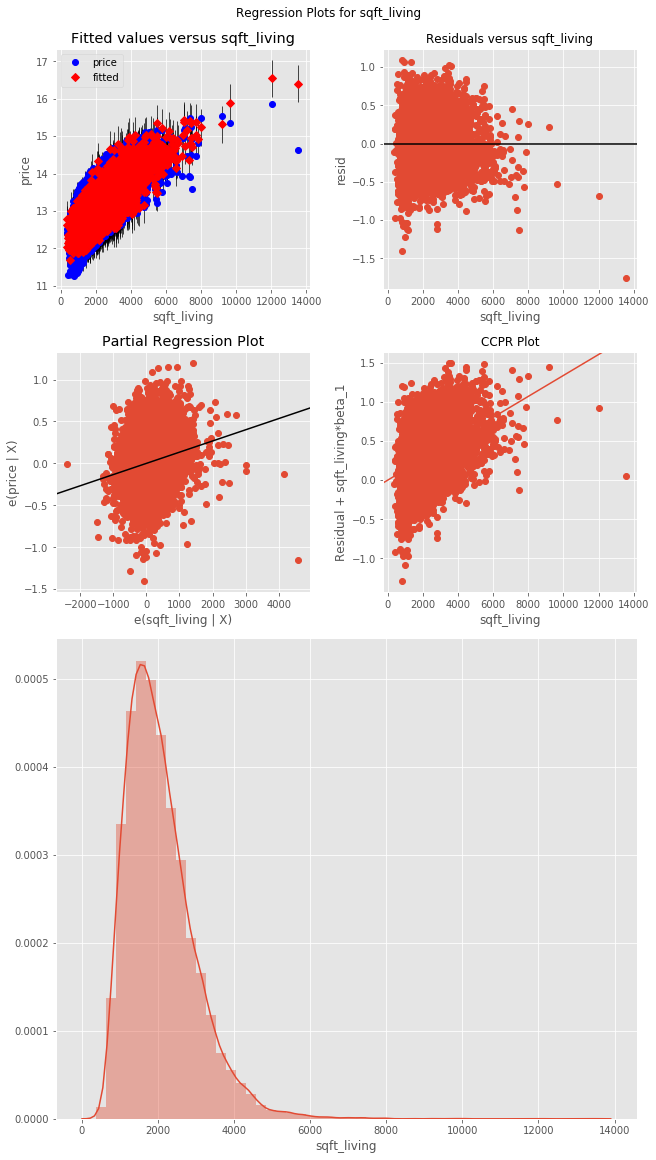

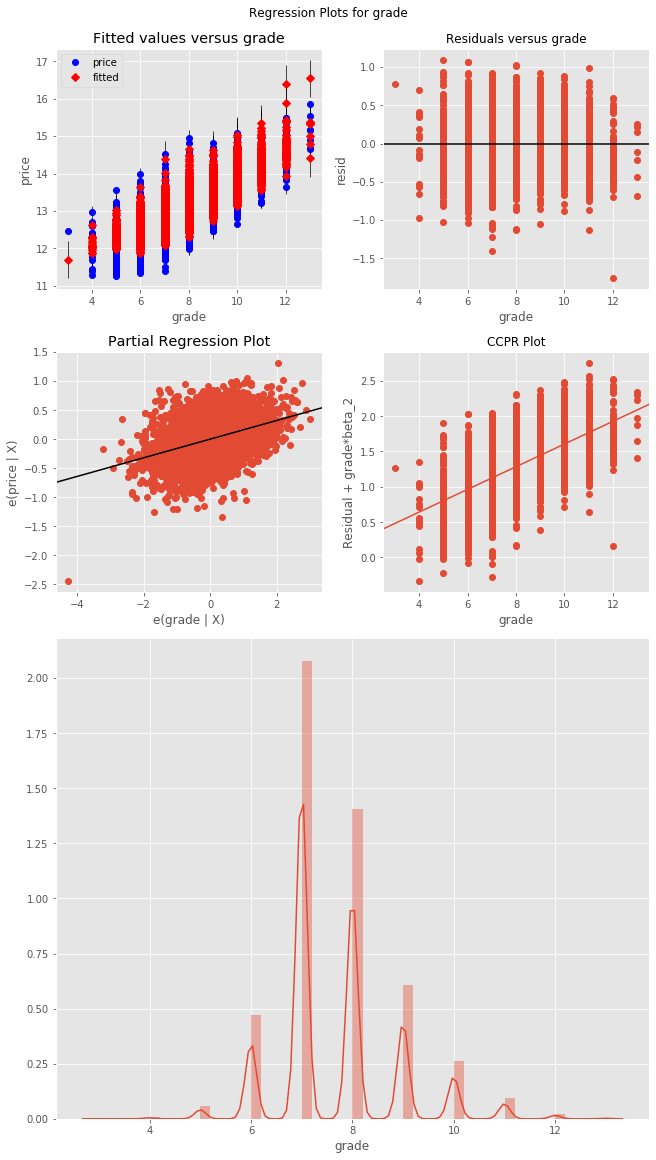

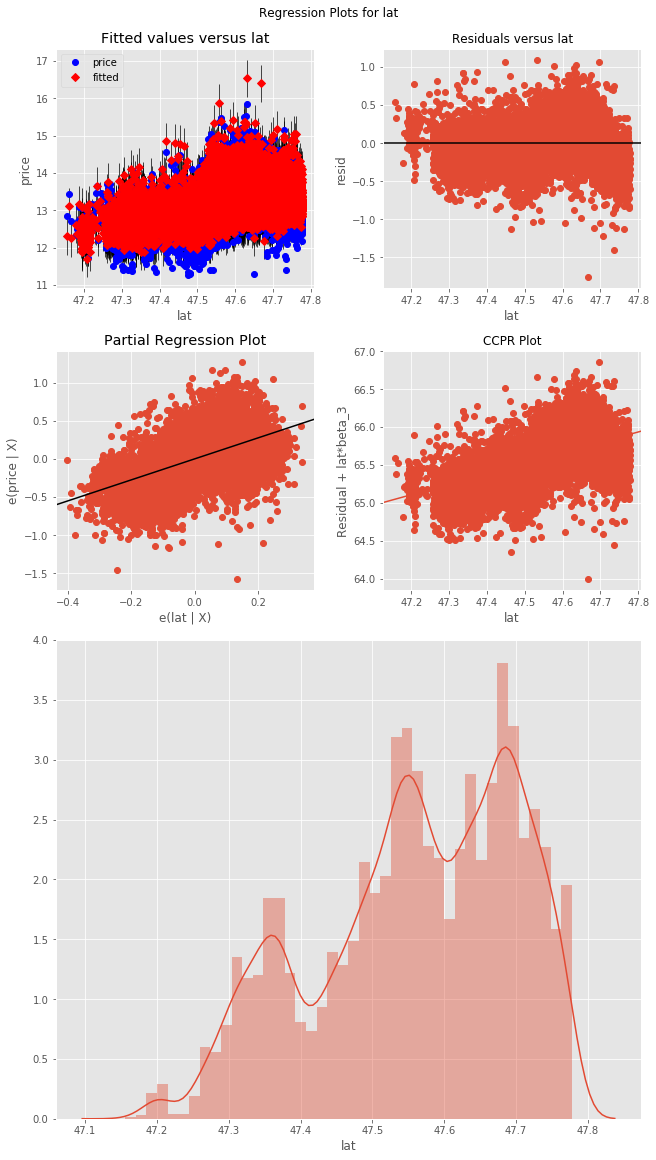

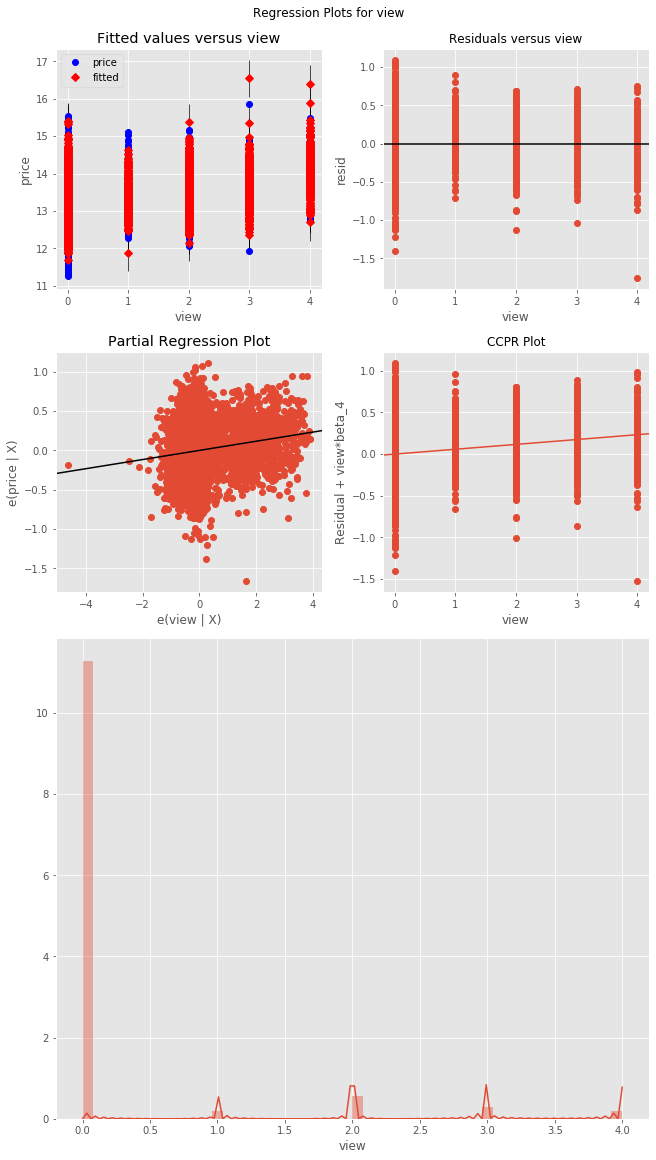

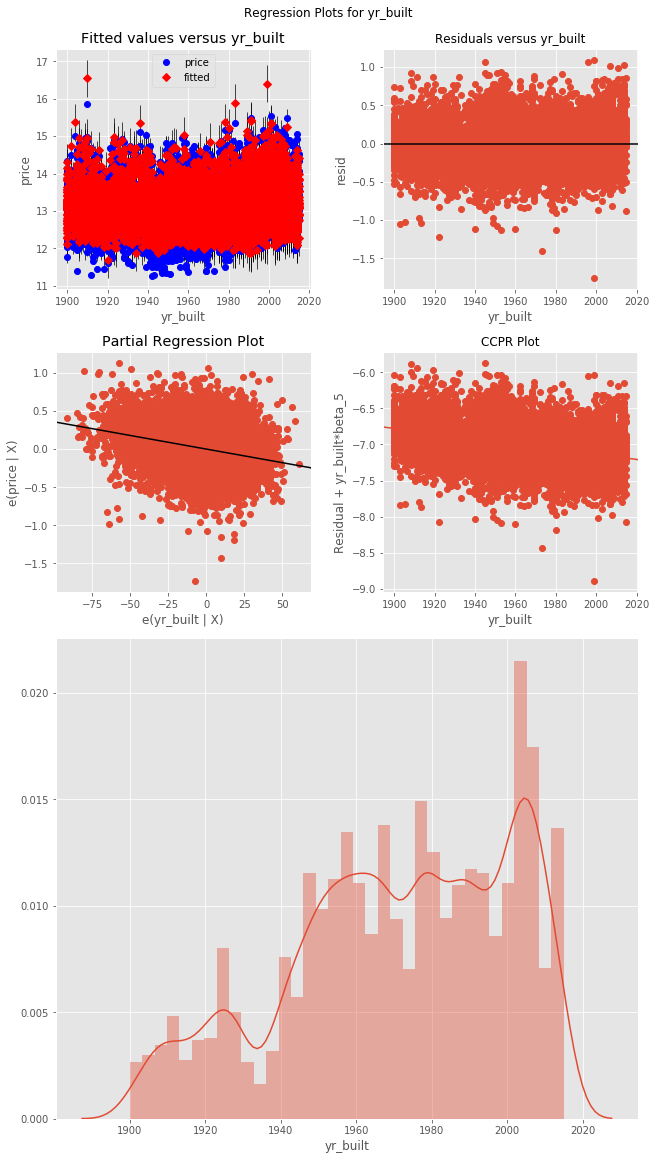

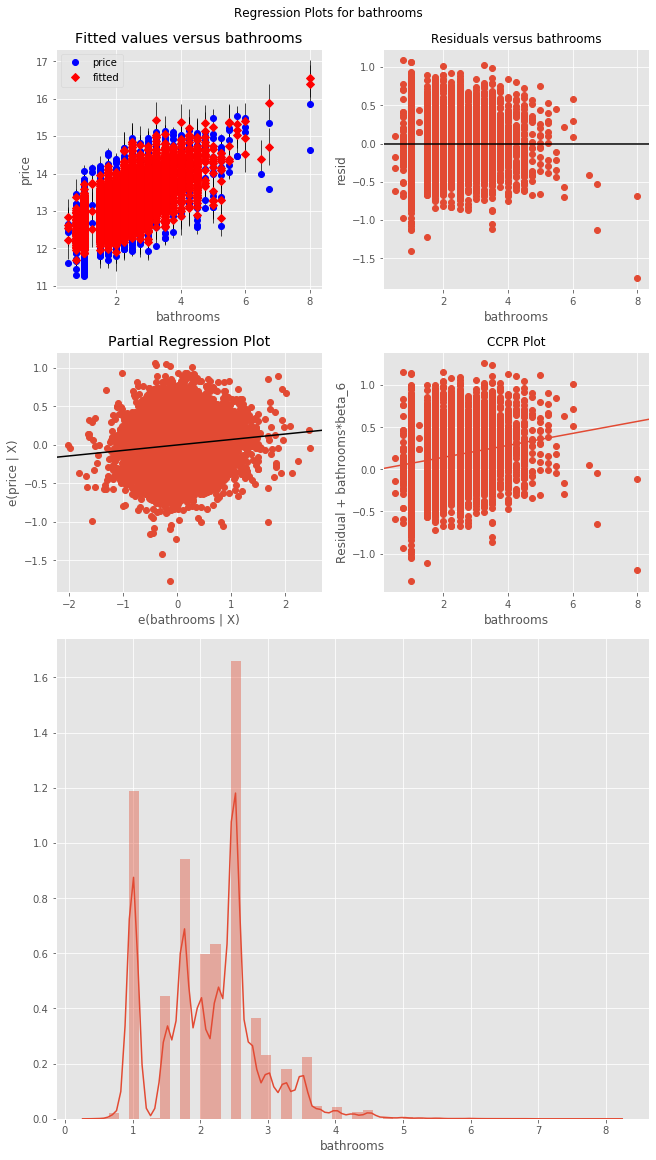

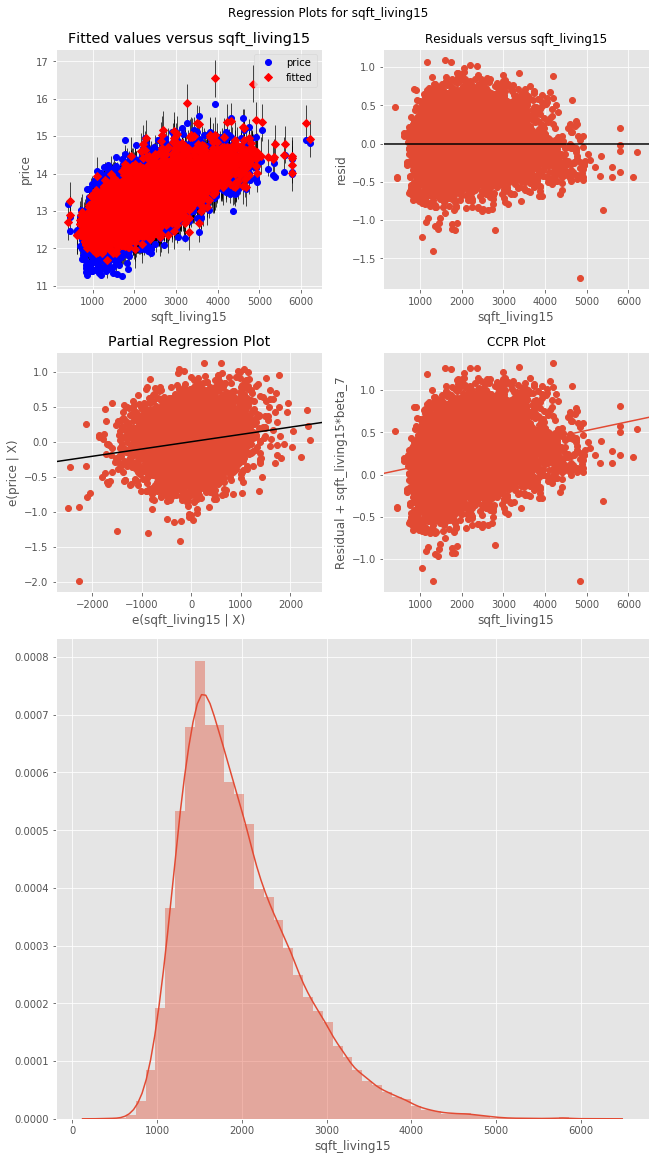

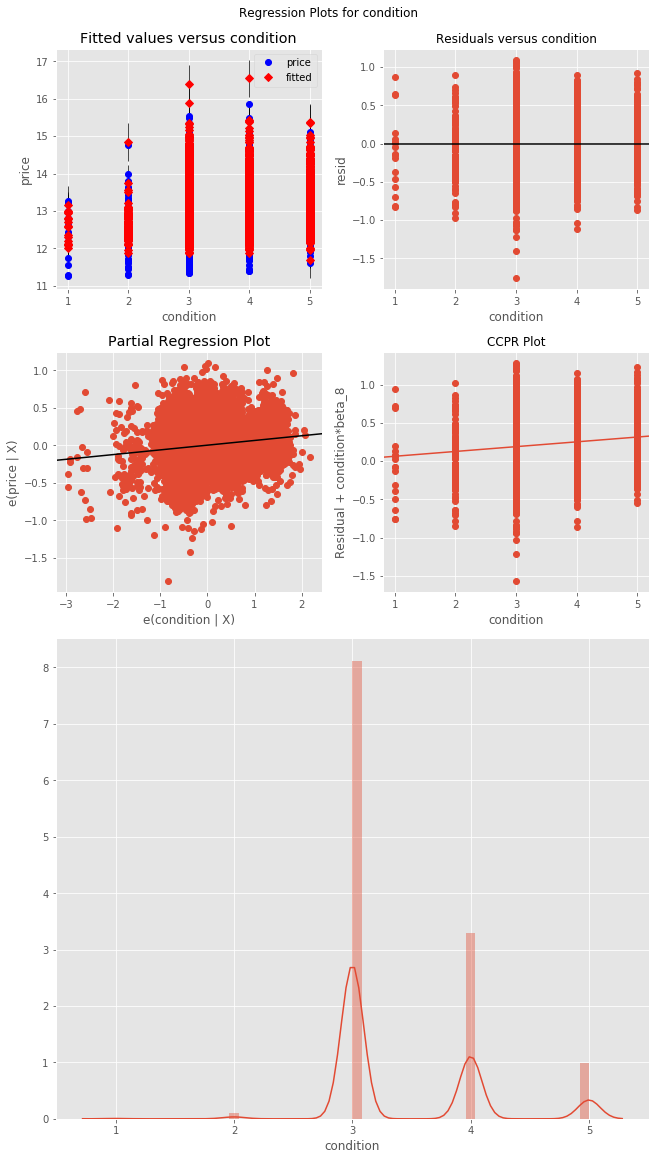

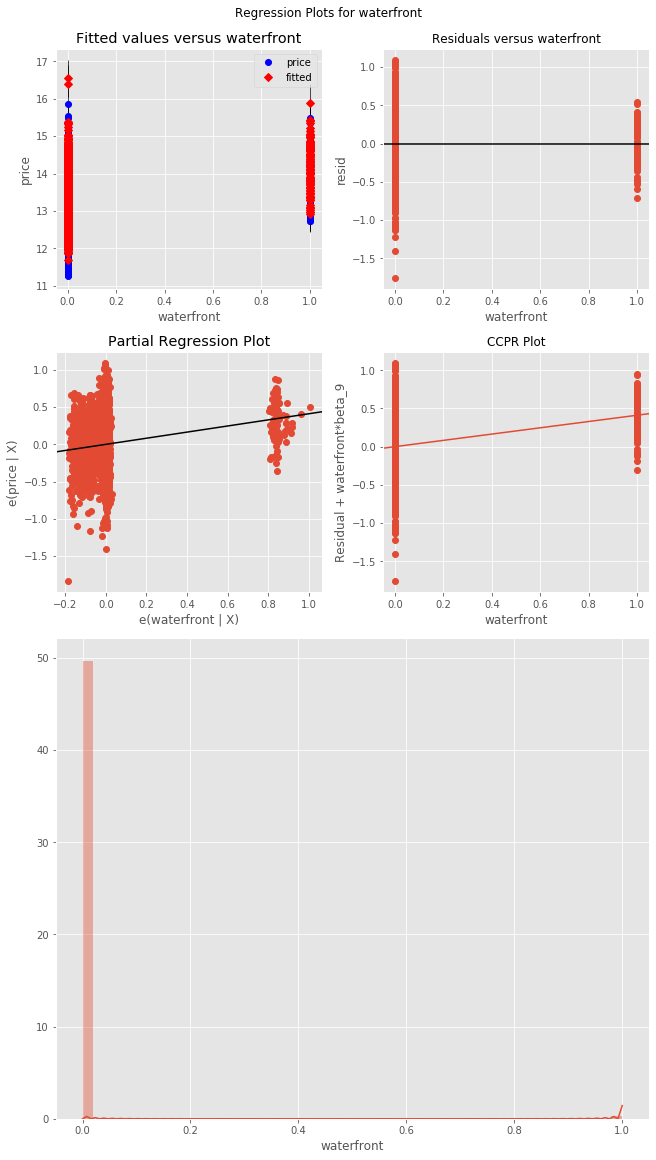

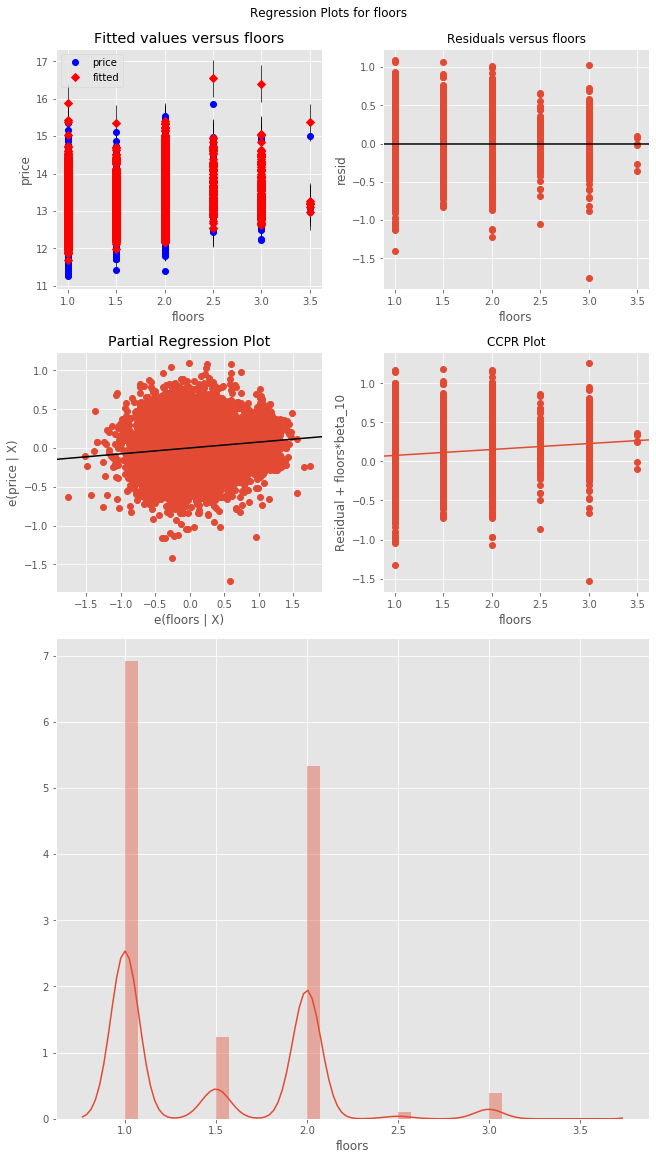

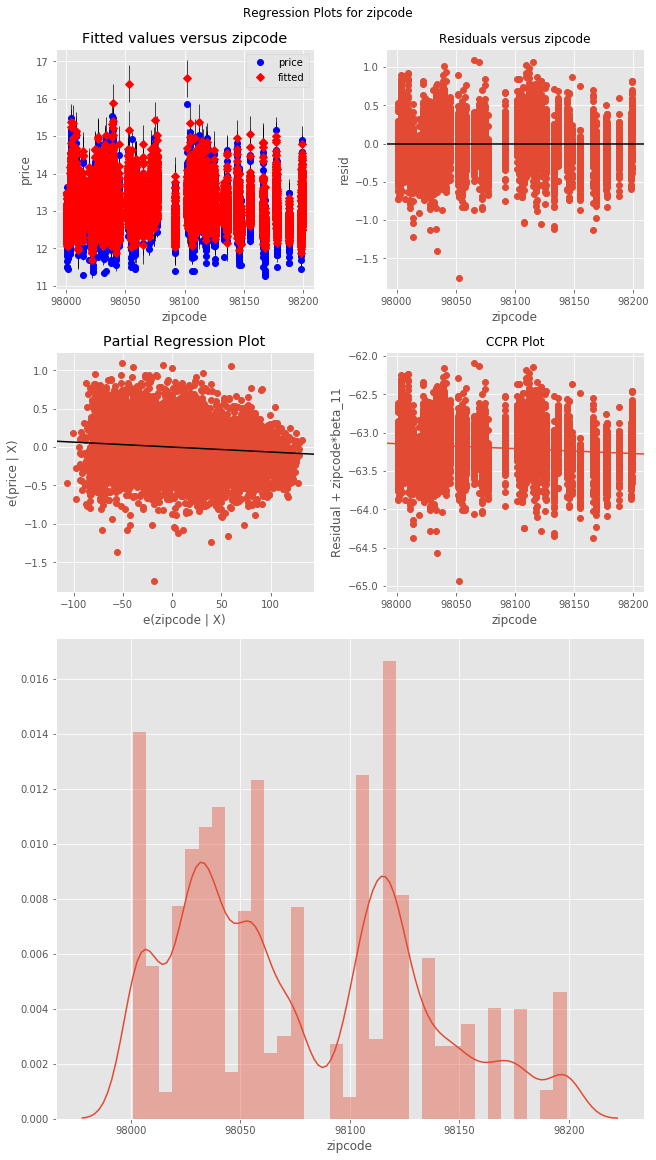

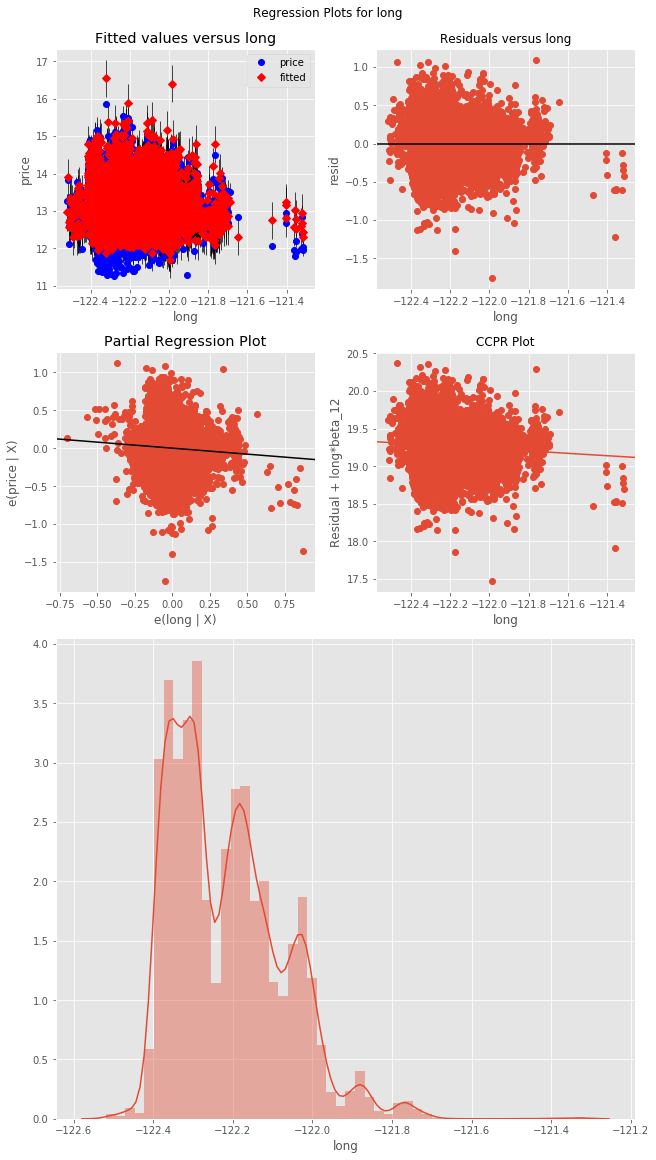

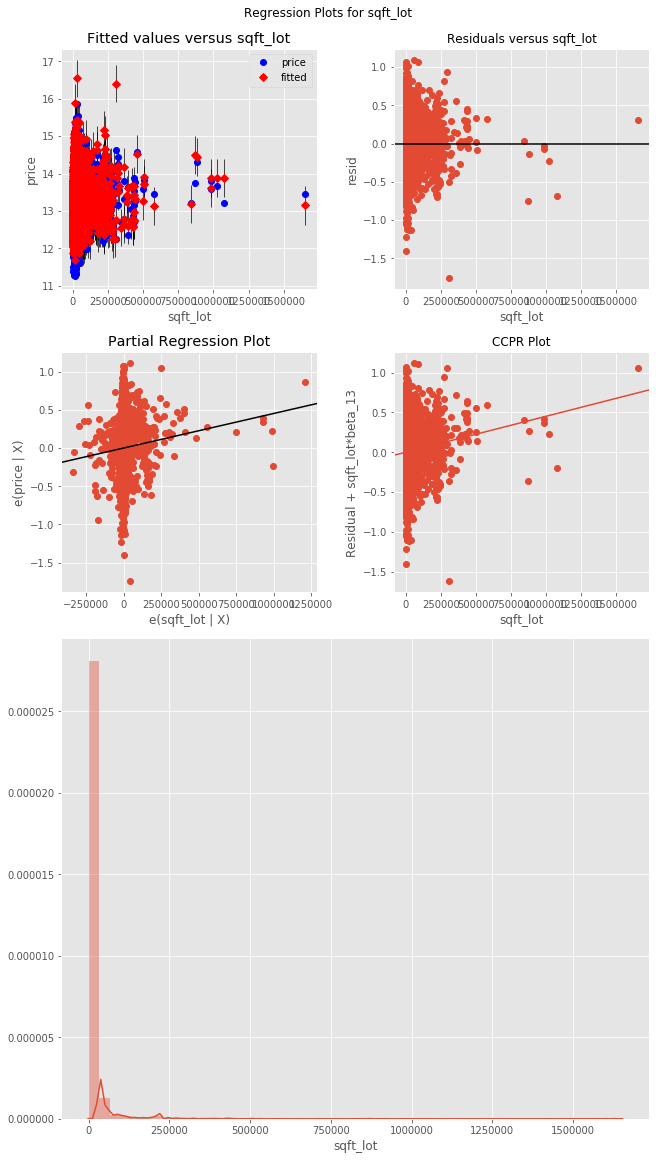

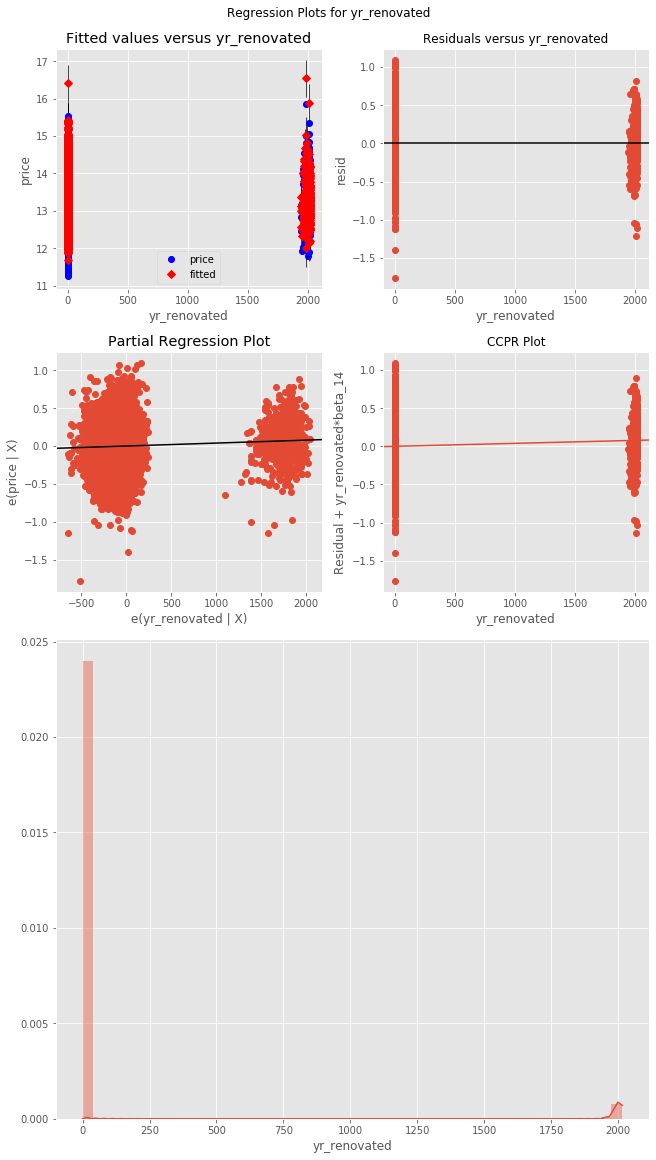

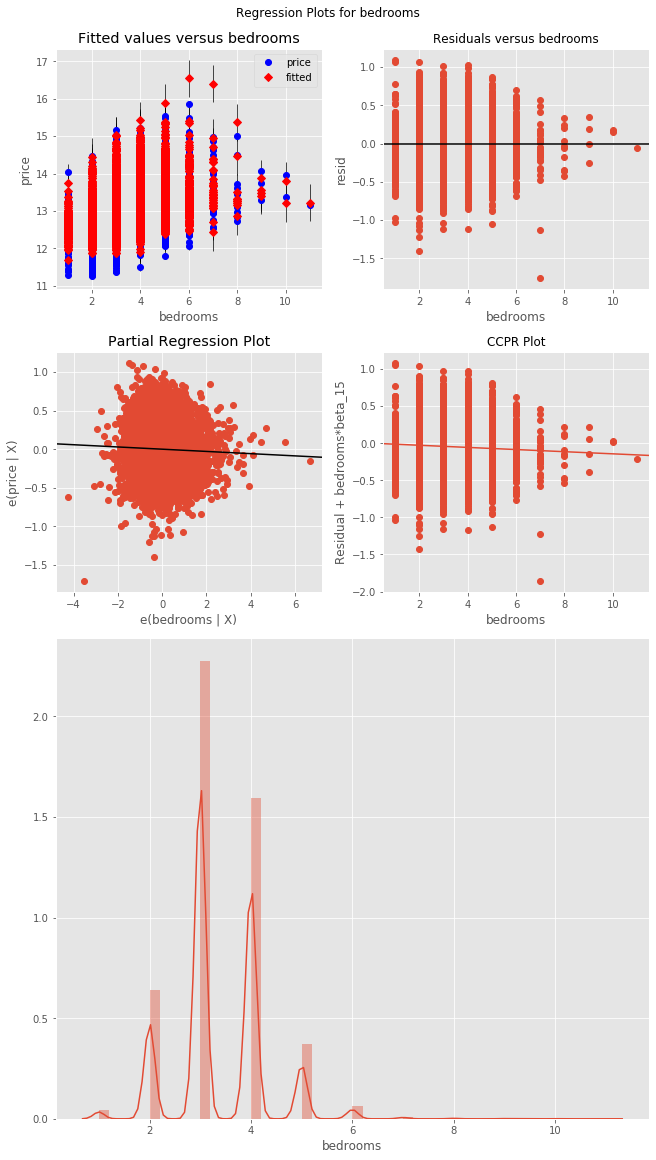

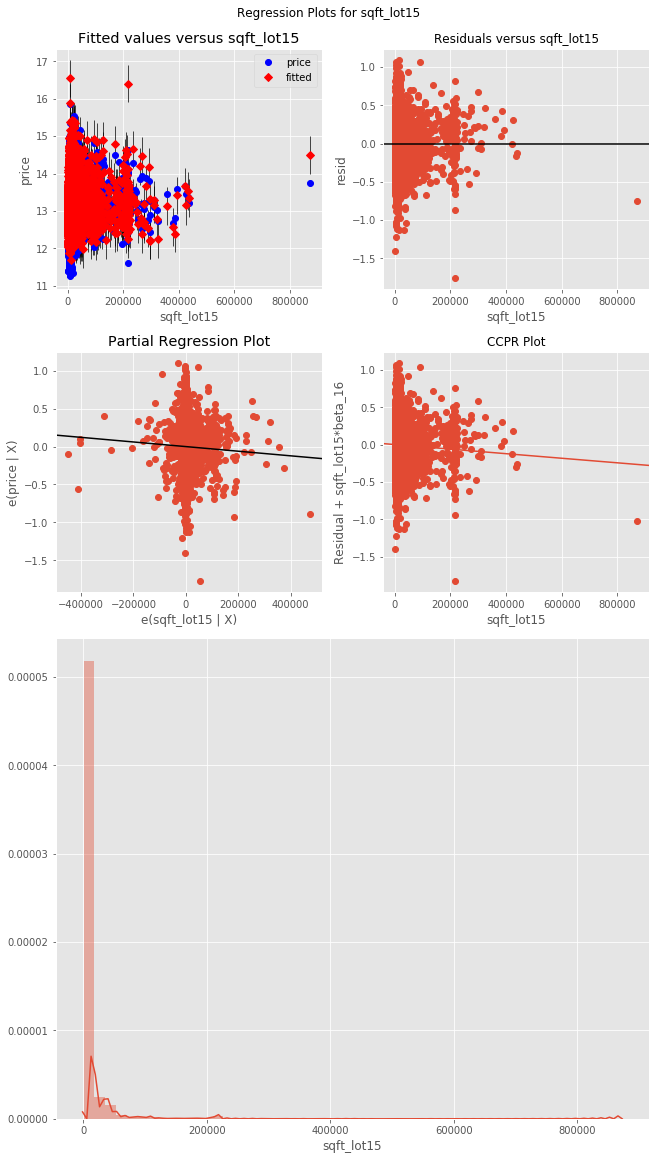

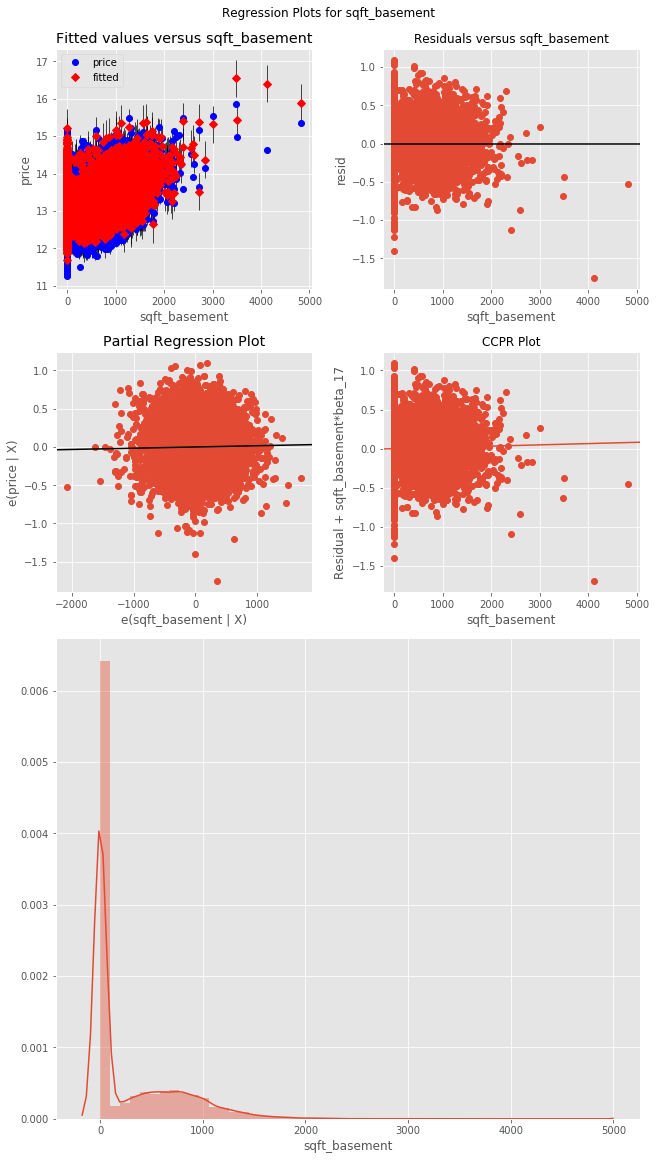

In [26]:
for idx, feat in enumerate(sel_features):        
    scjpnregression.feature_regression_summary(
        kchd_cleaned_with_log_transformed_target_df[sel_features]
        , idx
        , target
        , model_fit_results
        , display_regress_diagnostics=True
    )

It is clear from the above that, indeed, we do not have normal distrubutions of our predictors.

Therefore, we continue by scaling, normalizing, transforming, and categorizing our features as necessary.

## Step 4: EDA: Feature Scaling, Normalization, Transformation, and Categorization

### Step 4: EDA: Categorical vs. Continuous Feature "Classification"

Drawing from our observations from our original search for outliers, we see that **there are features which are *apparently* categorical**.

Additionally, we can get a visual feel for which features are *categorical* vs *continuous* with scatter-plots of their values versus the *target feature*: **price**.

The idea is to **separate apparent *categorical* features from *continuous* features**.

We will attempt to simultaneously improve the performance of our model, as well as address multicolinearity, hopefully *without dropping too many features*.

In our search for outliers earlier, we leveraged the function to list the sets of unique values of each feature.  As an added benefit, that function produces a result that computes the likelihood that a given feature is or isn't categorical based on the ratio of unique values it has to the the total number of observations.  This will of course vary from data set to data set.  But, referring back to those results, a quick look shows that our *apparent* categorical features have a *p_cat* threshold value of $0.99$.  (Note that I have invented this metric for the context of this project - i.e. it's not an "official" statistical metric as far as I know.)  I use the term "apparent" because the metric *p_cat* alone doesn't dictate for sure whether a given feature is categorical or not.  It is only a rough measure of it likelihood to be *categorical*.  Ultimately, whether a feature is categorical or not depends on its meaning and, of course, whether it is represents a quantitative measure, which is up to the feature definitiion.

So let's use this information now to partition the set of features into *continuous* and *categorical* subsets, based on $p\_cat \ge 0.99$.

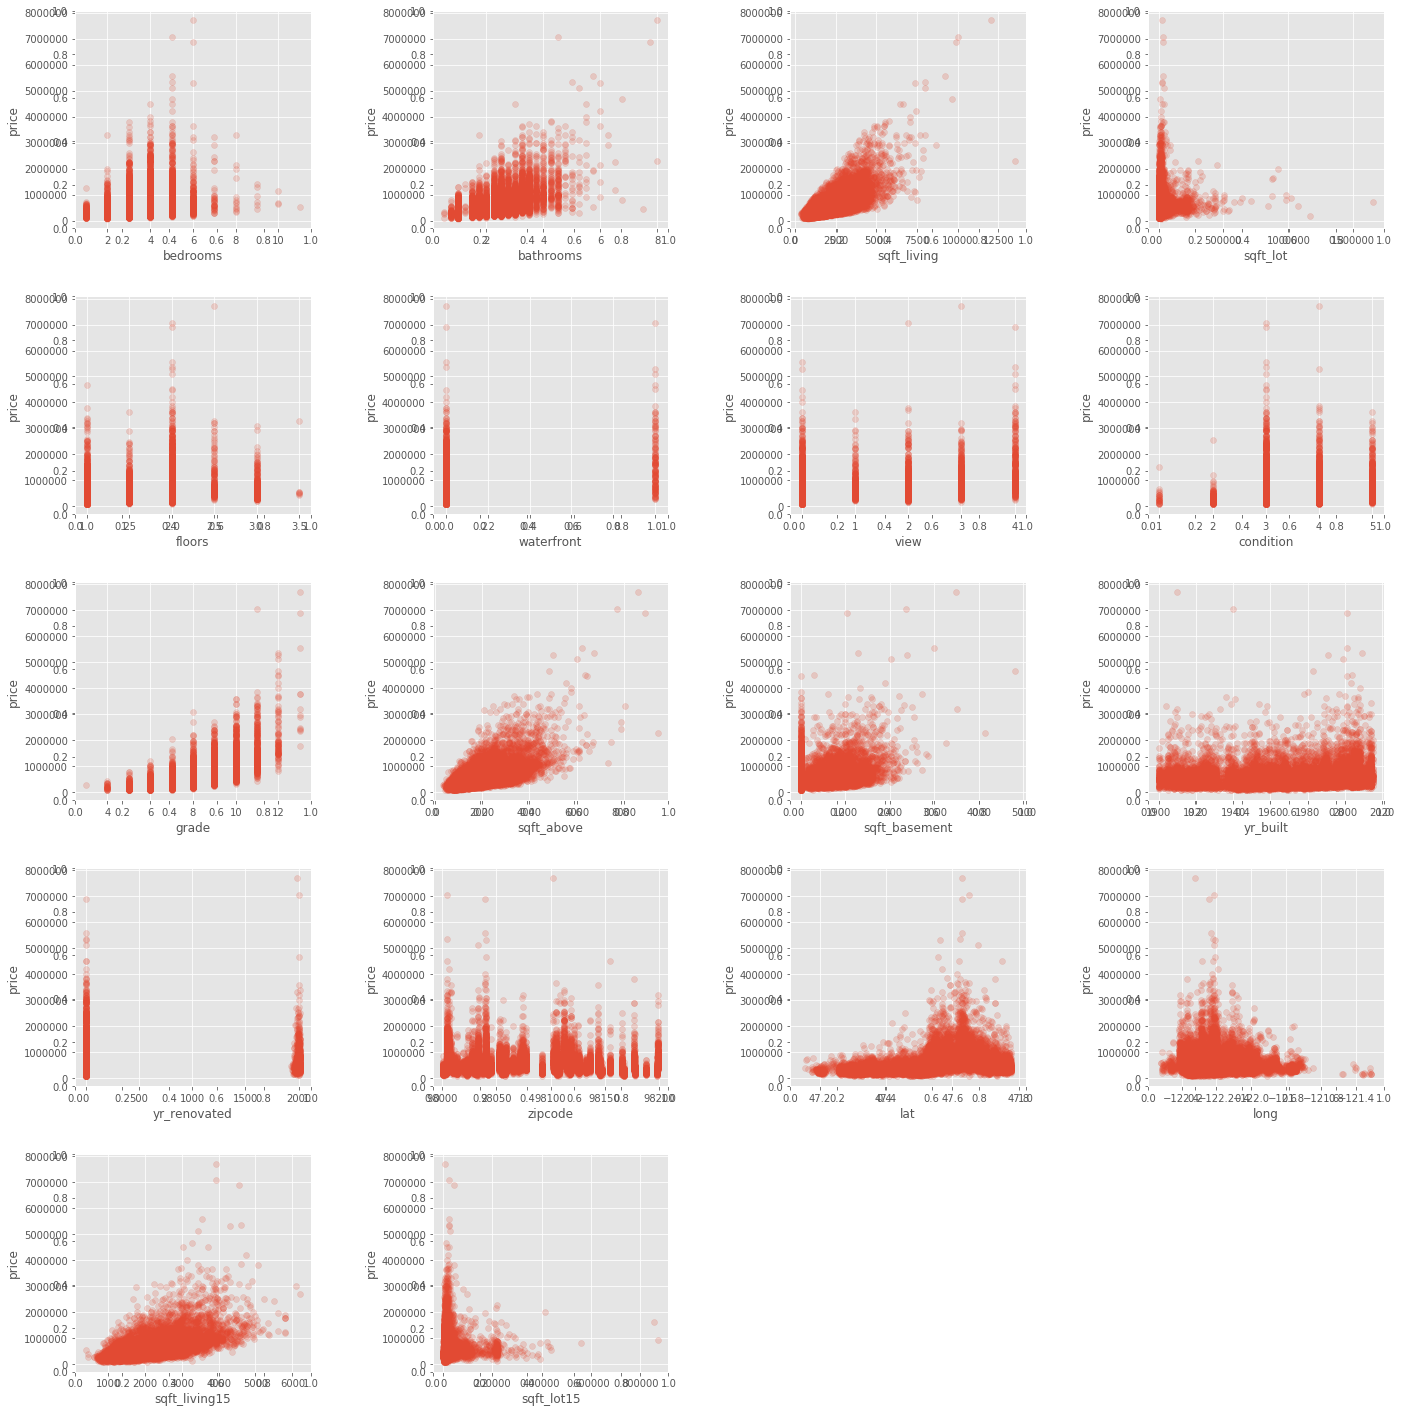

In [27]:
p_cat = 0.99

(
    kchd_cat_classification_df
    , categorical_features
    , continuous_features
) = scjpnregression.split_categorical(kchd_cleaned_df, p_cat, target)

### Step 4: EDA: Categorical vs. Continuous Feature "Classification"

Now that we have clearly identified and separated *continuous* vs. *categorical* features, we can take a look the ranges and distributions of our *continuous* features in order to determine whether they must be *tranformed* and/or *scaled*.

In [28]:
kchd_cleaned_df[continuous_features].describe().loc[['min', 'max']]

sqft_living   sqft_lot  sqft_above  sqft_basement      lat     long  \
min        370.0      520.0       370.0            0.0  47.1559 -122.519   
max      13540.0  1651359.0      9410.0         4820.0  47.7776 -121.315   

     sqft_living15  sqft_lot15  
min          399.0       651.0  
max         6210.0    871200.0

Based on the ranges \[*min*, *max*\] of continuous features, it is clear that they need to be at least *scaled*.  

Let's have a look at the distributions of each for some insight into whether or not we should first *log-transform* a given feature.

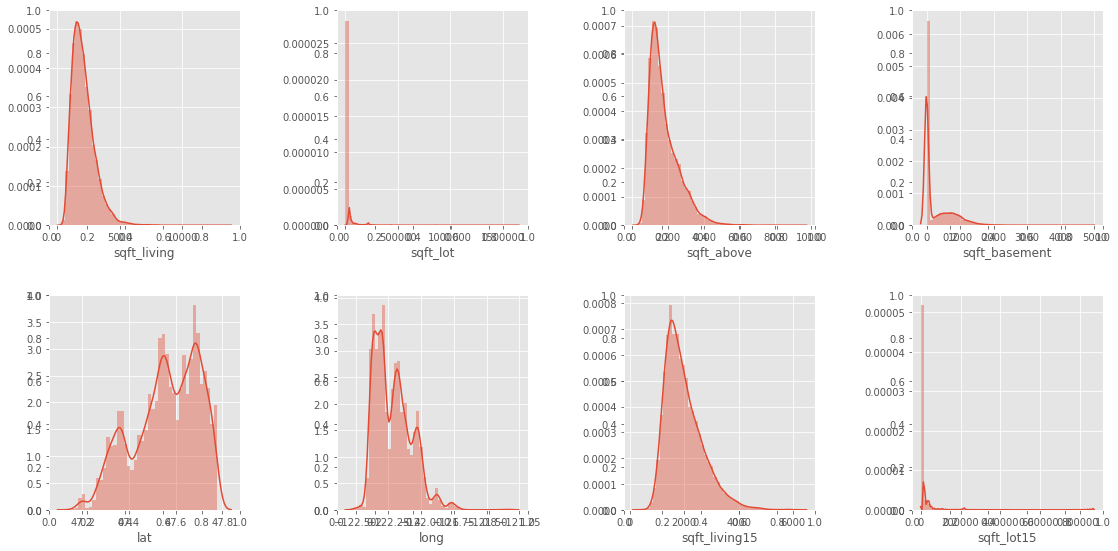

In [29]:
scjpnregression.histograms(kchd_cleaned_df[continuous_features])

s_html = "From the distributions above, we see that <b>all <i>continuous</i> features need to be scaled</b> but <b>they must <i>first</i> be log-transformed <i>when possible</i></b> in order to push their distributions more toward normal:<br><br><ul>"
for cont_feat in continuous_features:
    s_html += "<li><b>{}</b></li>".format(cont_feat)
s_html += "</ul>"
display(HTML(s_html))

### Step 4: EDA: Continuous Feature Transformation Preprocessing

Prior to log-transforming these features, we must pay careful attention to features with values $\le 0$ and either adopt a replacement heuristic for these values to make log-transformation possible OR we can opt to simply not transform such a feature.

Note that **long** contains negative values and also that **lat** and **long** are really components of an *ordered pair*.  Thus, if we *transform* or *scale* one (but not *translate*), we must do the same operation to the other.  Without doing anything to address negative values, we will not be able to use *log-transformation* on **long** (and subsequently **lat**).  

However, **we can perform *log-transformation* on *long* if we first *translate (shift to the right)* its *lower-bound* to $0$ by adding $-1 \cdot min(long)$ to the all values in the set**.  Note that we must follow up with a *hack* in order to perform *log-transformation* on values==$0$: **we will subsequently replace all instances of $0.0$ with $1$ *in order to make log-transformation possible* - note that $log(1)=0$**.

To summarize:
1. For **lat** and **long**:
    1. first *translate* the *range* of **long** to: $range_{transformed}(long)=[min(range_0(long))-min(range_0(long)), max(range_0(long))-min(range_0(long))]$; that is, $\forall v \in range_0(long): v_{transformed} = v-min(range_0(long))$
    2. since they constitute an *ordered pair*:
        1. *translation* of a componenent of the ordered pair - i.e. **long** - independently from the other is okay
        2. but  *transformation/scaling* operations must be done to both
2. For all continuous features (including **lat** and **long**), we will:
    1. replace all instances of 0.0 with 1 *in order to make log-transformation possible*, since $log(1)=0$
    2. do *min/max scaling*.
    
The following code preprocesses and prepares **lat** and **long** for *log-transformation*.

### Preprocess lat and long for *log-transformation*: add $-1 \cdot min(long)$ to the all values in the set, and then replace all instances of $0.0$ with $1$ 

In [30]:
#prep for log-tranformation
lt_cont_features = continuous_features.copy()
b_force_log_transform = True
if b_force_log_transform:
    kchd_cleaned_df['long'] = kchd_cleaned_df['long']-kchd_cleaned_df['long'].min() # translation to [0, max(range(long)) - min(range(long))]
    for lt_cont_feature in lt_cont_features:
        scjpnutils.clean_offending_values(
            kchd_cleaned_df
            , numeric_replacement_rules=
                {
                    lt_cont_feature: [(0.0, 1)]
                }
            , friendly_name_of_df="King County House Sales DF"
        )
df_has_neg_or_0 = kchd_cleaned_df[continuous_features] <= 0.0
for ltfeat in continuous_features:
    if df_has_neg_or_0[ltfeat].sum() > 0:
        lt_cont_features.remove(ltfeat)
if 'lat' in lt_cont_features and 'long' not in lt_cont_features:
    lt_cont_features.remove('lat')
if 'long' in lt_cont_features and 'lat' not in lt_cont_features:
    lt_cont_features.remove('long')

#min-max scaling    
mm_cont_features = continuous_features
print("\nThe following continuous features will be log-transformed:\n{}".format(lt_cont_features))
print("\nThe following continuous features will be min-max scaled:\n{}".format(mm_cont_features))

*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'sqft_living' column value replacement are: [(0.0, 1)]
Looking for rows with 'sqft_living' values [0.0] ...
There are no rows that contain values of 'sqft_living' in [0.0]!
*** CLEANING VALUES of King County House Sales DF: END ***
*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'sqft_lot' column value replacement are: [(0.0, 1)]
Looking for rows with 'sqft_lot' values [0.0] ...
There are no rows that contain values of 'sqft_lot' in [0.0]!
*** CLEANING VALUES of King County House Sales DF: END ***
*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'sqft_above' column value replacement are: [(0.0, 1)]
Looking for rows with 'sqft_above' values [0.0] ...
There are no rows that contain values of 'sqft_above' in [0.0]!
*** CLEANING VALUES of King County House Sales DF: END ***
*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'sqft_basement' column value

Both **lat** and **long** are now ready for *log-transformation*.

The code for *scaling*, *normalization*, and *log-transformation* is below.

### Scaling, Normalization, and Log-transformation Functions

We can now not only perform log-transformation on **lat** and **long**, but we can also perform min-max scaling on all of our continuous features (including **lat** and **long**).

### Step 4: EDA: Perform *log-transformation* on lat and long and *min-max scaling* on all continuous features

In [31]:
kchd_transformed_and_scaled_df = kchd_cleaned_df.copy()

# log-transformation
kchd_transformed_and_scaled_df = scjpnutils.log_transform(
    kchd_transformed_and_scaled_df
    , lt_cont_features
)

# min-max scaling
kchd_transformed_and_scaled_df = scjpnutils.min_max_scaling(
    kchd_transformed_and_scaled_df
    , mm_cont_features
)

**Transforming and scaling our *continuous* features yields the following ranges**:

In [32]:
kchd_transformed_and_scaled_df[continuous_features].describe().loc[['min', 'max']]

sqft_living  sqft_lot  sqft_above  sqft_basement  lat  long  \
min          0.0       0.0         0.0            0.0  0.0   0.0   
max          1.0       1.0         1.0            1.0  1.0   1.0   

     sqft_living15  sqft_lot15  
min            0.0         0.0  
max            1.0         1.0

### Step 4: EDA: Perform *log-transformation* and *min-max scaling* on target, price

Don't forget that **our target feature (*price*) should be log-transformed** (and scaled), as well, *based on the results from our Preliminary Linear Regression Model, v 2.0*. 

In [33]:
kchd_transformed_and_scaled_df[target].describe().loc[['min', 'max']]

min      78000.0
max    7700000.0
Name: price, dtype: float64

In [34]:
kchd_transformed_and_scaled_df = scjpnutils.min_max_scaling(
    scjpnutils.log_transform(kchd_transformed_and_scaled_df, [target])
    , [target]
)
kchd_transformed_and_scaled_df[target].describe().loc[['min', 'max']]

min    0.0
max    1.0
Name: price, dtype: float64

### Step 4: EDA: Preliminary Linear Regression Model, v. 3.0, after scaling/transforming continuous features (and target)

Now let's have a look at our scaled and transformed data.

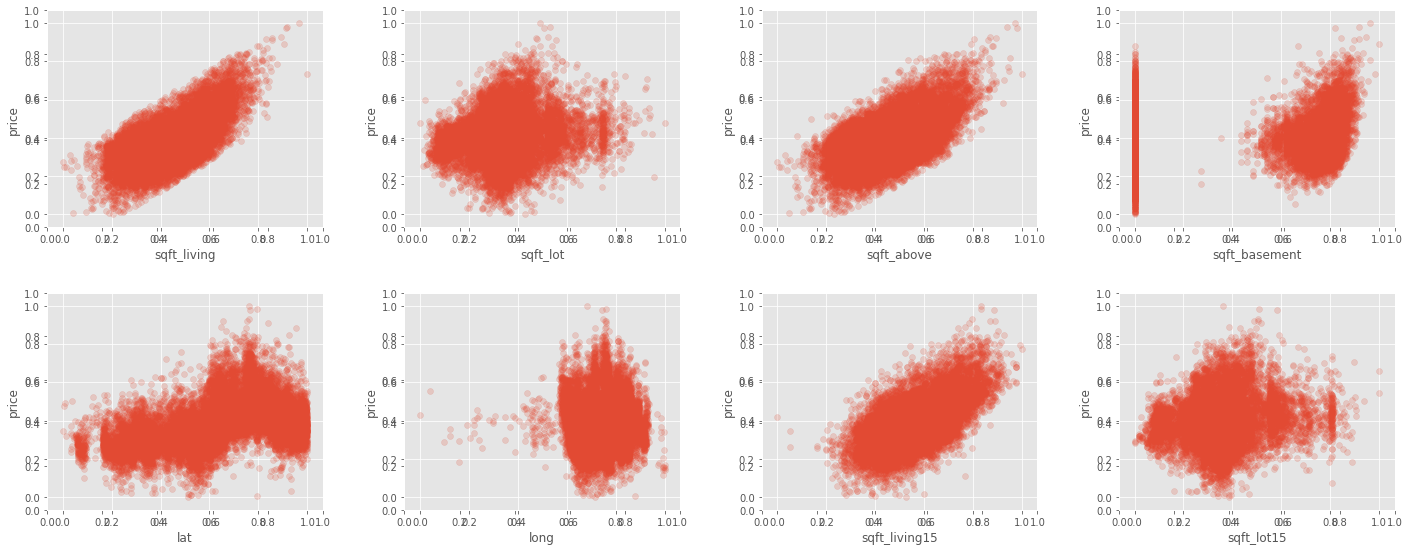

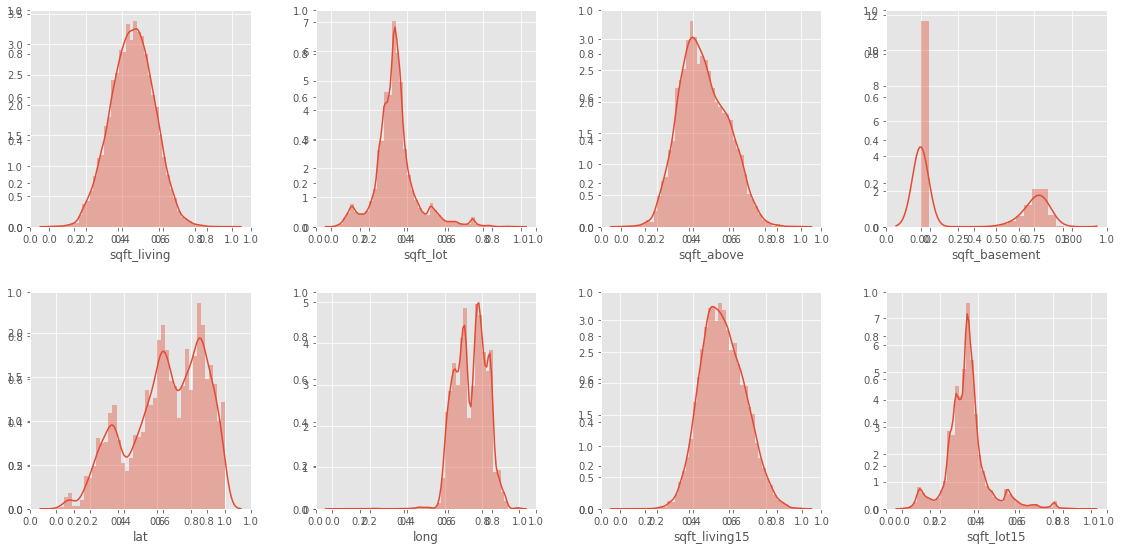

In [35]:
scjpnregression.scatter_plots(
    pd.concat(
        [
            kchd_transformed_and_scaled_df[target]
            , kchd_transformed_and_scaled_df[continuous_features]
        ]
        , axis=1
        , join='inner'
    )
    , target
)
scjpnregression.histograms(kchd_transformed_and_scaled_df[continuous_features]);

After *log-transforming* our *continuous* features (*as well as our target feature*), we see that their distributions are more normal, with the exception of **sqft_basement**, **lat**, and **long**.  

In terms of transformation, those features (**sqft_basement**, **lat**, and **long**) are about as good as they're going to get. 

Let's build a new linear regression model and see how it performs.

Note that we have not dealt with our *categorical* features yet.  This means that **our target, *price*, and our *contnuous* features will be in the range \[0, 1\] but our *categorical* features will not be**.

Nevertheless, **we should still expect the performance of a new linear regression based on this newly scaled/transformed data to perform better than the last one**, *Preliminary Linear Regression Model, v. 2.0*.

Feature selection method: <function stepwise_selection at 0x1c1a6809d8>
stepwise_selection: Add  sqft_living                    with p-value 0.0


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


stepwise_selection: Add  grade                          with p-value 0.0
stepwise_selection: Add  lat                            with p-value 0.0
stepwise_selection: Add  view                           with p-value 0.0
stepwise_selection: Add  yr_built                       with p-value 0.0
stepwise_selection: Add  bathrooms                      with p-value 3.02637e-86
stepwise_selection: Add  sqft_living15                  with p-value 8.29886e-102
stepwise_selection: Add  waterfront                     with p-value 1.96123e-72
stepwise_selection: Add  condition                      with p-value 9.72282e-72
stepwise_selection: Add  floors                         with p-value 1.38202e-55
stepwise_selection: Add  zipcode                        with p-value 5.49197e-33
stepwise_selection: Add  long                           with p-value 1.19134e-42
stepwise_selection: Add  bedrooms                       with p-value 1.96258e-27
stepwise_selection: Add  sqft_lot15                     wit

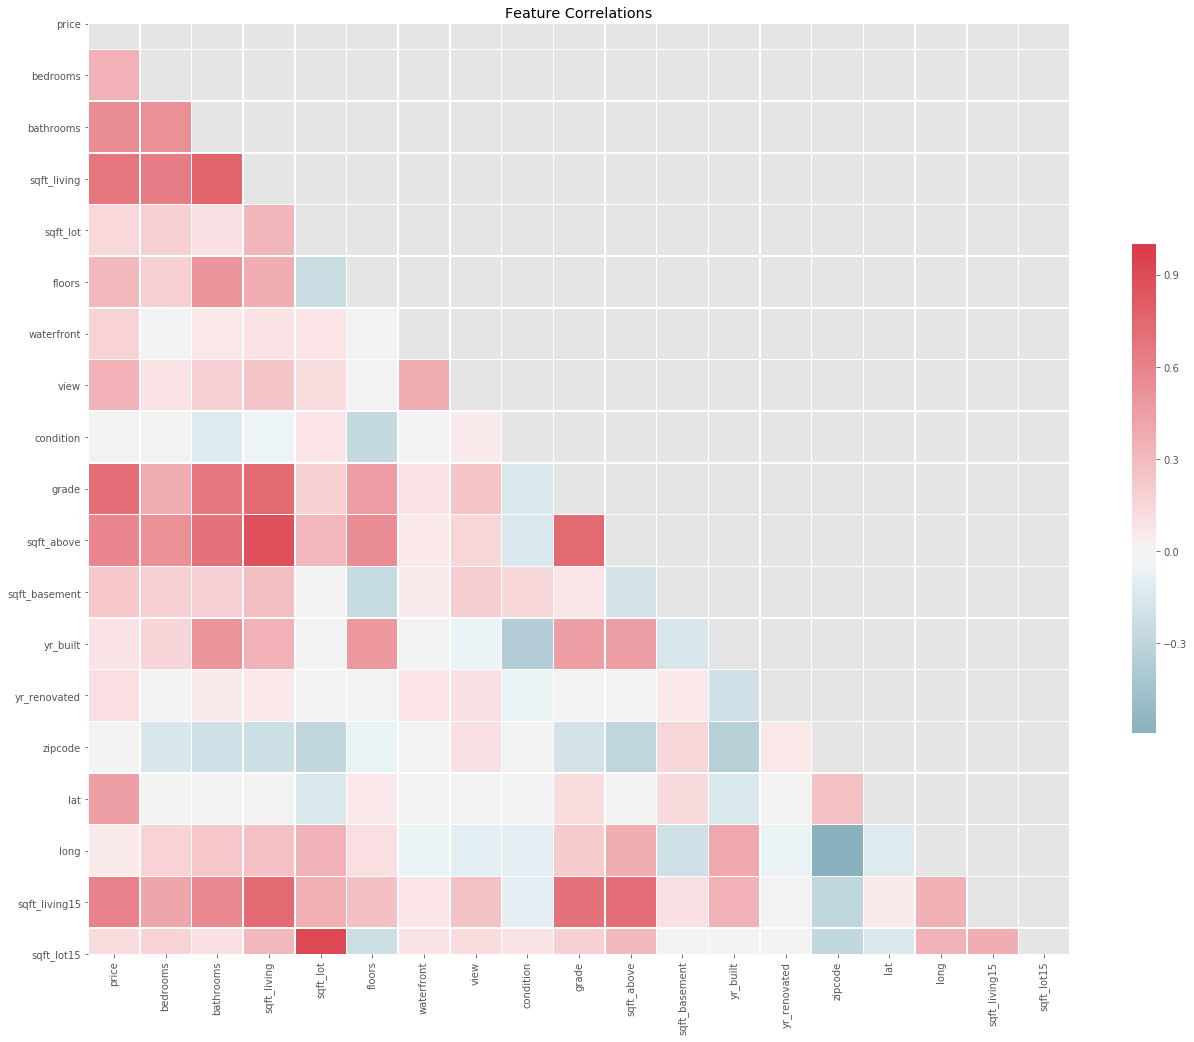

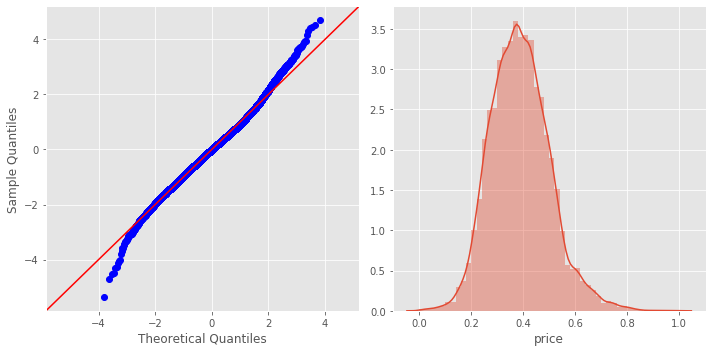

In [36]:
kchd_transformed_and_scaled_cont_with_target_df = kchd_transformed_and_scaled_df.copy()

prev_sel_features = sel_features
(
    sel_features
    , their_pvals
    , X_train
    , X_test
    , y_train
    , y_test
    , train_mse
    , test_mse, model
) = scjpnregression.lin_reg_model_from_auto_selected_features(
    kchd_transformed_and_scaled_cont_with_target_df
    , target
    , tr=tr
    , title="Preliminary Linear Regression Model, v. 3.0, after scaling/transforming continuous features:"
)

prev_good_vif_features = good_vif_features
prev_bad_vif_features = bad_vif_features
(model_fit_results, good_vif_features, bad_vif_features) = scjpnregression.model_fit_summary(
    kchd_transformed_and_scaled_cont_with_target_df
    , sel_features
    , their_pvals
    , target
    , model
    , tr
    , train_mse
    , test_mse
    , mv_r_sq_th
    , mv_mse_delta_th
    , mv_bad_vif_ratio_th
)

### Step 4: EDA: Preliminary Linear Regression Model, v. 3.0, after scaling/transforming continuous features (and target): Analysis

In [37]:
display(HTML("Look at that QQ plot! VERY NICE!  We see that our $R^2 = {}$ has indeed increased, as expected but not by much.".format(round(model_fit_results.rsquared, 3))))
display(HTML("Again, take a look at the difference in MSEs between our training and test partitions - note that we split based on a ${}$/${}$ ratio.".format(1-tr, tr)))
display(HTML("<b>The difference between MSE of our train/test partitions is still approximately ${}$, as expected.</b>".format(int(abs(train_mse-test_mse)))))
display(
    HTML(
        "<b>We see, in fact, that the bad VIF ratio - that is, measure of multicolinearity - has actually increased from {}% to {}%!</b>".format(
            round((len(prev_bad_vif_features)/len(prev_sel_features))*100, 2)
            , round((len(bad_vif_features)/len(sel_features))*100, 2)
        )
    )
)

With the exception of one or two outliers, **this model manifests a kurtosis that is clearly platykurtic**!  This is what we want since **platykurtic target distributions are stable and predictable, in the sense that there will rarely (if ever) be extreme (outlier) observations of the target**.

HOWEVER, **multicolinearity is still a problem and has, in fact, gotten worse**.

This is now likely due to the fact that, at this point, as previously stated, our target, **price**, and our *contnuous* features will be in the range \[0, 1\] but our *categorical* features will not be.

#### What can we do to improve its performance?
Before we consider dropping features as a means to deal with multicolinearity, let's see what effect *binning* our *categorical* features has on, not only multiconlinearity, but of the performance of our linear regression model in general.

But, for good measure, **let's use *cross-validation selection* to determine whether or not we have truly made the right decision in using ALL of our *continuous* features to build our models to predicts our target, *price***.

### Step 4: EDA: Use cross-validation to select the set of continuous features which best predicts price from ALL combinations of continuous features

Combinatorics is handy.  The idea is to run through every combination of ${n \choose r}$ features, where $n$ is the total number of *continuous* features we start with and $r$ varies from $1$ to $n$ and use *cross-validation* to select the combination that produces the least MSE.

The process goes likes this:
1. Start with $r=1$
2. How many ways are there to choose $r=1$ features from our set of all *continuous* features? Answer: ${n \choose r}=\frac{n!}{r! \cdot (n-r)!}$ ($=n$ when $r=1$) different ways to select $r=1$ features at a time.
3. Now we use *k-folds* ($k=10$ folds in our case) to *cross-validate-select* the feature that produces the minimum $\Delta MSE$ between test/train folds.
4. Whenever a "new" best (lowest $\Delta MSE$ is encountered, the procedure stores that feature-set.
5. Increment $r$ and repeat the process until $r=n$.

Note that the total number of combinations is $\sum_{r=1}^n {n \choose r} = 2^n-1$.  That number can grow quite large rather quickly.  For instance, if we did this to select from ALL of our features (both *continuous* and *categorical*) then, since $n=18$, $\sum_{r=1}^{18} {18 \choose r} = 2^{18}-1 = 262143$ possible combinations!  **Cross-validating every possible combination out of our total set of features (including *continuous* AND *categorical* features) over 10 folds will literally take almost all day, if not longer**.

This results in cross-validation selecting the best feature-combination that predicts the outcome, **price**, with the greatest accuracy (lowest $\Delta MSE$).

So let's run cross-validation to select the best set of **continuous** features now and let it guide us as to whether or not we should drop any of them.

In [38]:
(cv_sel_cont_features, neg_mse, to_drop) = scjpnregression.cv_selection(
    kchd_transformed_and_scaled_df.drop(target, axis=1)[continuous_features]
    , kchd_transformed_and_scaled_df[[target]]
    , tr=tr
    , folds=10
    , scoring_method="neg_mean_squared_error"
    , fn_better_score=lambda neg_mse, best_neg_mse: abs(neg_mse) < abs(best_neg_mse)
)

new best neg_mean_squared_error score: -0.007163637952252564, from feature-set combo: ['sqft_living']


new best neg_mean_squared_error score: -0.007065793117677431, from feature-set combo: ['sqft_living', 'sqft_lot']
new best neg_mean_squared_error score: -0.004808061244411213, from feature-set combo: ['sqft_living', 'lat']


new best neg_mean_squared_error score: -0.004805999107110641, from feature-set combo: ['sqft_living', 'sqft_lot', 'lat']
new best neg_mean_squared_error score: -0.004776878830277335, from feature-set combo: ['sqft_living', 'sqft_above', 'lat']
new best neg_mean_squared_error score: -0.004723211111781487, from feature-set combo: ['sqft_living', 'lat', 'long']
new best neg_mean_squared_error score: -0.0045372155254775545, from feature-set combo: ['sqft_living', 'lat', 'sqft_living15']


new best neg_mean_squared_error score: -0.00451175205115288, from feature-set combo: ['sqft_living', 'sqft_lot', 'lat', 'sqft_living15']
new best neg_mean_squared_error score: -0.00434524990378496, from feature-set combo: ['sqft_living', 'lat', 'long', 'sqft_living15']


new best neg_mean_squared_error score: -0.004341779957527432, from feature-set combo: ['sqft_living', 'sqft_lot', 'lat', 'long', 'sqft_living15']
new best neg_mean_squared_error score: -0.0043134046517058, from feature-set combo: ['sqft_living', 'sqft_above', 'lat', 'long', 'sqft_living15']
new best neg_mean_squared_error score: -0.004276054547522795, from feature-set combo: ['sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15']


new best neg_mean_squared_error score: -0.004259778840790453, from feature-set combo: ['sqft_living', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15']


new best neg_mean_squared_error score: -0.0042592068129604695, from feature-set combo: ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15']
new best neg_mean_squared_error score: -0.004256350053237782, from feature-set combo: ['sqft_living', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


new best neg_mean_squared_error score: -0.004253650214208042, from feature-set combo: ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


### Step 4: EDA: Use cross-validation to select the set of continuous features which best predicts price from ALL combinations of continuous features: Analysis

In [39]:
if len(to_drop) > 0:
    for drop_feat in to_drop:
        continuous_features.remove(drop_feat)
        print("dropped cv-seletion suggested feature {} from continuous_features".format(drop_feat))
    print("after dropping cv-seletion suggested features, continuous_features are now:\n{}".format(continuous_features))
    
    kchd_transformed_and_scaled_cont_with_target_df = pd.concat(
        [
            kchd_transformed_and_scaled_cont_with_target_df[target]
            , kchd_transformed_and_scaled_cont_with_target_df[continuous_features]
            , kchd_transformed_and_scaled_cont_with_target_df[categorical_features]
        ]
        , axis=1
        , join='inner'
    )

    prev_sel_features = sel_features
    (
        sel_features
        , their_pvals
        , X_train
        , X_test
        , y_train
        , y_test
        , train_mse
        , test_mse, model
    ) = scjpnregression.lin_reg_model_from_auto_selected_features(
        kchd_transformed_and_scaled_cont_with_target_df
        , target
        , tr=tr
        , title="Preliminary Linear Regression Model, v. 4.0, after dropping cv-selection continuous features:"
    )

    prev_good_vif_features = good_vif_features
    prev_bad_vif_features = bad_vif_features
    (model_fit_results, good_vif_features, bad_vif_features) = scjpnregression.model_fit_summary(
        kchd_transformed_and_scaled_cont_with_target_df
        , sel_features
        , their_pvals
        , target
        , model
        , tr
        , train_mse
        , test_mse
        , mv_r_sq_th
        , mv_mse_delta_th
        , mv_bad_vif_ratio_th
    )
    
kchd_transformed_and_scaled_df = kchd_transformed_and_scaled_cont_with_target_df

VERY INTERESTING, INDEED!

**Cross-validation suggests dropping *none* of our continuous features! We can now proceed with confidence that our selection of *contnuous* features (ALL of them) results in a model that will most accurately predict our target, *price*.**

**We now move on to *categorizing/binning categorical features* now that we are confident in our selection of *continuous* features**.

### Step 4: EDA: Categorization/Binning Categorical Features

Now, before we get to officially *categorizing* our categorical features, we can refer to their ranges and sizes of their value sets in order to get some guidance on how we should "bin" them.

For small-sized value sets, we can partition the categories (value set) based on the number of values.

But at some point this will become too taxing since each bin will add another column to the data set after categorization.

So, for larger-sized value sets, for example if the size of the value set is larger than 10, we might need to get creative with our binning strategy.

Let's have a look at the categorical value set ranges once more.

In [40]:
display(HTML("<b>Categorical Feature Ranges:</b><br><br>"))
scjpnutils.print_df(kchd_cat_classification_df[['name', 'dtype', 'unique_vals']].set_index('name'))
scjpnutils.print_df(kchd_transformed_and_scaled_df[categorical_features].describe().loc[['min', 'max']])

From the above, we note that:
- **bathrooms** has a strange range of values, \[0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.5, 7.75, 8.0\], but we can handle this by appropriate binning into:
    - $16$ bins: [0, 0.5), [0.5, 1), [1, 1.5), [1.5, 2), [2, 2.5), [2.5, 3), [3, 3.5), [3.5, 4), [4, 4.5), [4.5, 5), [5, 5.5), [5.5, 6), [6, 6.5), [6.5, 7), [7, 7.5), [7.5, 8)
    - we bin in increments of 0.5 since, according to the [feature definitions](https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices) in this data set, **bathrooms** is "Number of bathrooms, where .5 accounts for a room with a toilet but not shower"
    - we could have addressed the values with 0.25 and 0.75 components in the cleaning phase via a *rounding* replacement heuristic but then we would have had to decide whether either should round up or down, to the nearest 0.5 increment; *binning* effectively accomplishes the same and with less work (since we have to do binning anyway); additionally, by binning in increments of 0.5, we adhere close to the definition of **bathrooms** listed in the [feature definitions](https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices); **we are interested in observing the impact that adding additional bathrooms *with and without a shower* has on potential sale price**
- **zipcode** has a large value set; so we will need to devise an appropriate binning scheme in order to reduce the number of bins to a manageable count
    - **zipcode** is a bit trickier since a the value of a home can vary drastically from one zip code to the next;  additionally, intuitively we might think there is some relationship between **zipcode** and $(lat, lon)$; so we are left with some choices:
        - retain the **zipcode** feature and accept that we might lose some fidelity in binning multiple zipcodes together in each bin,
        - drop **zipcode** since $(lat, lon)$ likely correlates to it anyway and with greater fidelity, or
        - leave it as is and use the default categorical binning semantic below - for this iteration, this is the option we will choose
- for all other categorical features from the list above, since the count of categorical values is low, we simply create partitions according to the *cardinality* of the set of categorical values of each - this is our *default* binning scheme

We are now prepared to "bin" our categorical features.  But instead of doing it manually, I have written the function below to capture this process programatically since it encapsulates all of the steps required to run full linear regression experiments from here on out.

The following function encapsulates the full linear regression experiment process.

### Step 4: EDA: Toward Full Regression v. 1.0: transformed, scaled, and categorized features
We're almost ready to perform our first full regression on our transformed, scaled and categorized data.

Note that the above process rebuilds the bins with each run (but saved in an output data frame).  This was done intentionally in order for the entire process to be encapsulated within a single function call, to facilitate running new and different linear regression experiments.

But, the `run_full_regression_experiment` function requires the caller to pass in a defined "callback" function argument (`fn_init_bin_bases`) which houses the logic for building any "special-handling" binning semantics.

For instance, both **yr_built** and **yr_renovated** have binning bases too large to rely on default binning semantics (one bin for each value).  Additionally, **yr_renovated** uses value $0$ to indicate that a home has not been renovated.  But the next value in that category is $1934$.  So we can't simply create a basis for its bins equal to `range(min(yr_renovated), max(yr_renovated))` since this would result in 1933 additional columns in the corresponding data frame after binning.  Not only that but none of them would be used!  ... which would result in a monumental, unnecessary hit to memory (and elapsed time) used to run the regression!  Hence, **yr_renovated** truly does require "special handling".  And this is the purpose of the `fn_init_bin_bases` function.


### Step 4: EDA: Explanation of special-handling binning logic for **yr_renovated**
The logic is actually quite simple.  We simply first remove the minimum value (0) and then partition based on some predifined desirable interval size.  I have set my interval size to $10$ (years).  This results in roughly 13 bins or so.  Very nice!  It also makes sense since it probably wouldn't make much difference (sale-price wise) if I renovated my house 1 or 5 years ago.  But 10 years probably does make a bit of a difference.  Anyway, after that, the 0 value is appended back into the basis and the basis is re-sorted.

My implementation for it is below.

In [41]:
def my_init_bin_bases(df, categorical_features, max_yr_bins=10):
    special_handling_categoricals_map = dict()
    default_handling_categoricals_list = []
    
    if len(categorical_features) > 0:        
        # create "special-handling" bins    
        if 'bathrooms' in df.columns:
            special_handling_categoricals_map['bathrooms'] = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]
        if 'floors' in df.columns:
            special_handling_categoricals_map['floors'] = [1, 2, 3, 4]    
        yr_feat_list = ['yr_built', 'yr_renovated']    
        for yr_feat in yr_feat_list:
            if yr_feat in df.columns:
                len_interval = 10
                basis = None
                has_zero = df[yr_feat].isin([0]).sum() > 0
                if has_zero: # drop the zero then partition
                    basis = list(df[df[yr_feat] != 0][yr_feat].unique())
                else:
                    basis = list(df[yr_feat].unique())
                basis = list(range(min(basis), max(basis), len_interval))
                if has_zero:
                    basis.append(0)
                basis = sorted(basis)
                special_handling_categoricals_map[yr_feat] = basis
        #print(special_handling_categoricals_map)

        # create list of categorical features which should use default binning semantic
        default_handling_categoricals_list = categorical_features.copy()
        for special_handling_categorical in special_handling_categoricals_map.keys():
            default_handling_categoricals_list.remove(special_handling_categorical)
        for def_handling_cat in default_handling_categoricals_list:
            if def_handling_cat not in df.columns:
                default_handling_categoricals_list.remove(def_handling_cat)
        #print(default_handling_categoricals_list)
    
    return (default_handling_categoricals_list, special_handling_categoricals_map)

We are now ready for Full Regression v. 1.0!

### Step 4: EDA: Full Regression, v. 1.0

Feature selection method: <function stepwise_selection at 0x1c1a6809d8>


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


stepwise_selection: Add  floors_e1__2i                  with p-value 0.0
stepwise_selection: Add  grade_e10__11i                 with p-value 0.0
stepwise_selection: Add  grade_e6__7i                   with p-value 0.0
stepwise_selection: Add  sqft_above                     with p-value 0.0
stepwise_selection: Add  sqft_basement                  with p-value 0.0
stepwise_selection: Drop floors_e1__2i                  with p-value 0.0529718
stepwise_selection: Add  lat                            with p-value 0.0
stepwise_selection: Add  sqft_living15                  with p-value 1.45311e-234
stepwise_selection: Add  view_e3_0__4_0i                with p-value 8.60583e-196
stepwise_selection: Add  long                           with p-value 3.28122e-153
stepwise_selection: Add  grade_e9__10i                  with p-value 2.42552e-110
stepwise_selection: Add  grade_e8__9i                   with p-value 5.8691e-112
stepwise_selection: Add  condition_e2__3i               with p-value 1.190

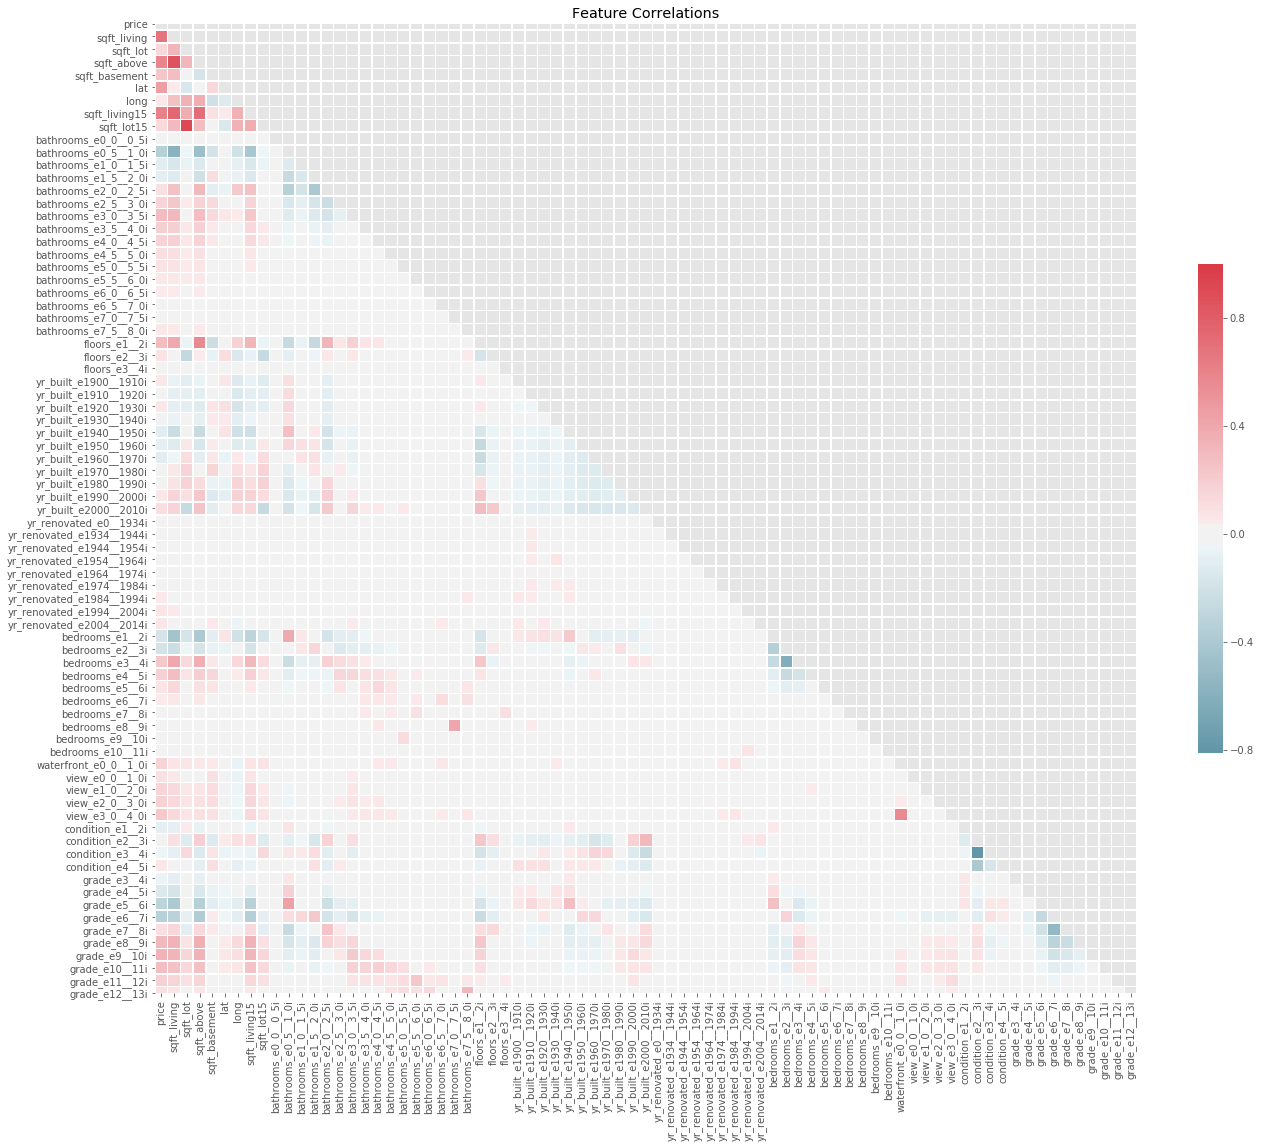

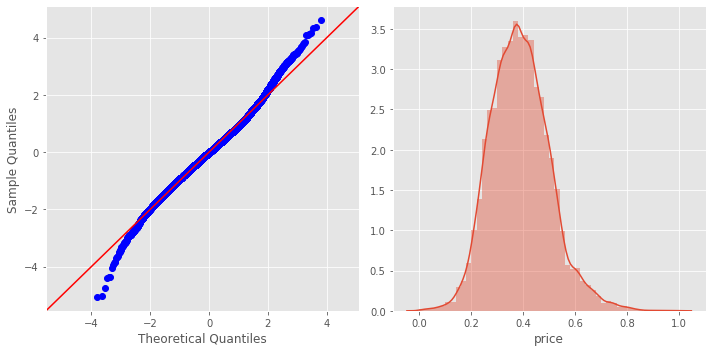

In [42]:
prev_sel_features = sel_features
prev_good_vif_features = good_vif_features
prev_bad_vif_features = bad_vif_features

do_final_model_validation = True
if do_final_model_validation:
    (
        sel_features
        , model_fit_results
        , train_mse
        , test_mse
        , good_vif_features
        , bad_vif_features
        , kchd_transformed_and_scaled_and_categorized_df
    ) = scjpnregression.run_full_regression_experiment(
        kchd_transformed_and_scaled_df
        , target
        , to_drop=['zipcode']
        #, to_drop=[]
        , tr=tr
        , mv_r_sq_th=mv_r_sq_th
        , mv_mse_delta_th=mv_mse_delta_th
        , mv_bad_vif_ratio_th=mv_bad_vif_ratio_th
        , p_cat=p_cat
        , fn_init_bin_bases=my_init_bin_bases
        , cont_and_cat_features_tuple=(continuous_features, categorical_features)
        , title="Full Regression, v. 1.0"
    )
    #summarize_multicolinearity(kchd_transformed_and_scaled_df, target, corr_filter_threshold=model_fit_results.rsquared)

### Step 4: EDA: Full Regression v. 1.0: Analysis

In [43]:
display(
    HTML(
        "The QQ plot is not as attractive as it does exhibit more outliers by virtue of tail deviation! But we do see that our <b>$R^2 = {}$ has increased again</b>, and is becoming quite impressive.".format(
            round(model_fit_results.rsquared, 3)
        )
    )
)
display(
    HTML(
        "<b>The difference between MSE of our train/test partitions is still very, very low at approximately ${}$, as expected.</b>".format(
            int(abs(train_mse-test_mse))
        )
    )
)
display(
    HTML(
        "Finally, <b>the bad VIF ratio - that is, measure of multicolinearity - has impressively dropped from {}% to {}% and now results in passing model validation conditions!</b>".format(
            round((len(prev_bad_vif_features)/len(prev_sel_features))*100, 2)
            , round((len(bad_vif_features)/len(sel_features))*100, 2)
        )
    )
)

The models we are producing manifest kurtoses which are becoming "more" (closer to) mesokurtic than leptokurtic as we go.  **The kurtosis manifested in this model is now clearly platykurtic.**. That's a good thing.  Again, this is what we want since **platykurtic target distributions are stable and predictable, in the sense that there will rarely (if ever) be extreme (outlier) observations of the target**.

Since this model passes all three conditions of our assessment criteria, as well as manifesting platykurtic kurtosis, we have, therefore, confirmed that we now have a valid basis (data set) upon which we can conduct prediction experiments.

The final question remains: **have we mitigated multicolinearity?**

Let's see...

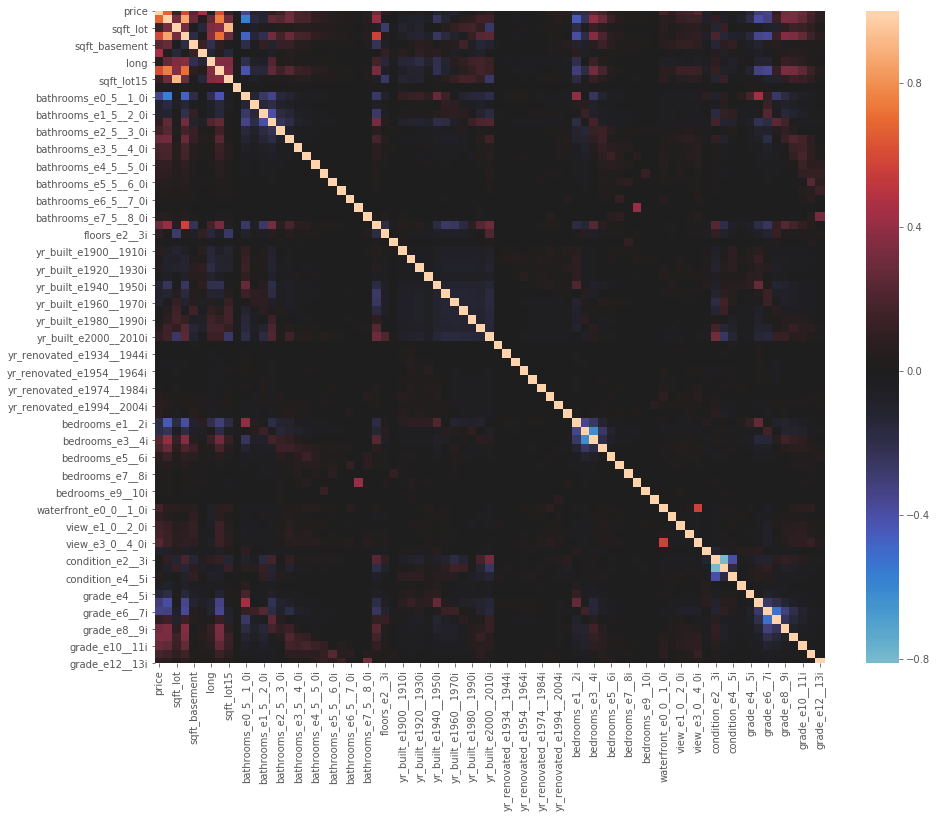

sqft_living 86.0% correlated to sqft_above
sqft_lot 92.0% correlated to sqft_lot15
sqft_above 86.0% correlated to sqft_living
sqft_lot15 92.0% correlated to sqft_lot
condition_e2__3i -81.0% correlated to condition_e3__4i
condition_e3__4i -81.0% correlated to condition_e2__3i

most severe correlation: ('sqft_living', [('sqft_above', 0.86)])


({'sqft_living': [('sqft_above', 0.86)],
  'sqft_lot': [('sqft_lot15', 0.92)],
  'sqft_above': [('sqft_living', 0.86)],
  'sqft_lot15': [('sqft_lot', 0.92)],
  'condition_e2__3i': [('condition_e3__4i', -0.81)],
  'condition_e3__4i': [('condition_e2__3i', -0.81)]},
 ('sqft_living', [('sqft_above', 0.86)]))

In [44]:
scjpnregression.summarize_multicolinearity(
    kchd_transformed_and_scaled_and_categorized_df
    , target
    , corr_filter_threshold=model_fit_results.rsquared
)

That colinearity matrix is IMPRESSIVE!  **Since the colinearity matrix for this model is almost ALL BLACK, we can confidently say that multicolinearity has indeed been mitigated in this model!**

## Characteristics of Final Linear Regression Model which BEST predicts price

In [45]:
s_html = "To summarize the model which BEST predicts our target, <b>price</b>, has the following characteristics:<ol>"
s_html += "<li>All <i>continuous</i> features have been selected via <i>cross-validation</i> of 10 folds and are therefore ALL used <i>with confidence</i>!</li>"
s_html += "<li>The target, <b>price</b>, has been <i>log-transformed</i> and <i>min-max scaled</i>.</li>"
s_html += "<li>All <i>continuous</i> features have been <i>log-transformed</i> and <i>min-max scaled</i>.</li>"
s_html += "<li>All <i>categorical</i> features have been used.</li>"
s_html += "<li>All <i>categorical</i> features have been <i>binned</i> (<i>categorized</i>).</li>"
s_html += "<li>Because all <i>categorical</i> features have been <i>binned</i>, <i>multicolinearity</i> has been <i>almost entirely mitigated</i>.</li>"
s_html += "<li>$R^2={}$</li>".format(model_fit_results.rsquared)
s_html += "<li>$\\Delta MSE={}$</li>".format(abs(test_mse - train_mse))
good_vif_ratio = len(good_vif_features)/len(sel_features)
bad_vif_ratio = 1 - good_vif_ratio
s_html += "<li>bad VIF ratio = ${}$%</li>".format(round(bad_vif_ratio*100,2))
s_html += "</ol>"
display(HTML(s_html))

## Step 5: Run linear regression experiments to answer real questions
We will attempt to answer the following questions:
1. As a whole, do structural features or location influence home sale price more?
2. Given a set of required features, what can an arbitrary buyer expect to pay?
3. As a seller, which set of $n$ structural features can I enhance to boost the final sale price of my home in King's County?

### Step 5: Question 1: *As a whole, do structural features or location influence home sale price more?*

#### Step 5: Question 1: Specifying "structural features" vs. "location"
According to the definitions provided for our data set, the following features are "structural":
- **bedrooms**
- **bathrooms**
- **sqft_living**
- **sqft_lot**
- **floors**
- **waterfront**
- **condition**
- **grade**
- **sqft_above**
- **sqft_basement**
- **yr_built**
- **yr_renovated**

And here our the features based on "locastion"
- **lat**
- **long**

It can be argued that **zipcode** and $(lat, long)$ are correlated, with more findelity derived from $(lat, long)$, so we simply opted to drop **zipcode** from consideration for this reason.

new best neg_mean_squared_error score: -0.011543470122085928, from feature-set combo: ['bedrooms']
new best neg_mean_squared_error score: -0.009162405878349916, from feature-set combo: ['bathrooms']
new best neg_mean_squared_error score: -0.007163637952252564, from feature-set combo: ['sqft_living']
new best neg_mean_squared_error score: -0.00664545104903181, from feature-set combo: ['grade']


new best neg_mean_squared_error score: -0.0065134746146887895, from feature-set combo: ['bedrooms', 'grade']
new best neg_mean_squared_error score: -0.006490595145778761, from feature-set combo: ['bathrooms', 'grade']
new best neg_mean_squared_error score: -0.005965809325766405, from feature-set combo: ['sqft_living', 'grade']
new best neg_mean_squared_error score: -0.005759931561098956, from feature-set combo: ['grade', 'yr_built']


new best neg_mean_squared_error score: -0.005634229653415803, from feature-set combo: ['bedrooms', 'grade', 'yr_built']
new best neg_mean_squared_error score: -0.005211806047804648, from feature-set combo: ['bathrooms', 'grade', 'yr_built']
new best neg_mean_squared_error score: -0.00505618911796373, from feature-set combo: ['sqft_living', 'grade', 'yr_built']


new best neg_mean_squared_error score: -0.005026363582405208, from feature-set combo: ['bedrooms', 'sqft_living', 'grade', 'yr_built']
new best neg_mean_squared_error score: -0.004947072318997646, from feature-set combo: ['bathrooms', 'sqft_living', 'grade', 'yr_built']
new best neg_mean_squared_error score: -0.0049302909920109165, from feature-set combo: ['sqft_living', 'sqft_lot', 'grade', 'yr_built']


new best neg_mean_squared_error score: -0.004895021304402054, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'grade', 'yr_built']
new best neg_mean_squared_error score: -0.004893685658289147, from feature-set combo: ['bedrooms', 'sqft_living', 'sqft_lot', 'grade', 'yr_built']
new best neg_mean_squared_error score: -0.00486231091133379, from feature-set combo: ['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'yr_built']
new best neg_mean_squared_error score: -0.004850102139307902, from feature-set combo: ['bathrooms', 'sqft_living', 'waterfront', 'grade', 'yr_built']
new best neg_mean_squared_error score: -0.004816811300532421, from feature-set combo: ['sqft_living', 'sqft_lot', 'waterfront', 'grade', 'yr_built']


new best neg_mean_squared_error score: -0.0048077100684662056, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'yr_built']
new best neg_mean_squared_error score: -0.004807141745232007, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'waterfront', 'grade', 'yr_built']
new best neg_mean_squared_error score: -0.00478769297282797, from feature-set combo: ['bedrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'grade', 'yr_built']
new best neg_mean_squared_error score: -0.0047543407209001114, from feature-set combo: ['bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'grade', 'yr_built']


new best neg_mean_squared_error score: -0.004709485264636455, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'grade', 'yr_built']


new best neg_mean_squared_error score: -0.004696266275908493, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'grade', 'yr_built']
new best neg_mean_squared_error score: -0.004690923002598759, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'condition', 'grade', 'yr_built']


new best neg_mean_squared_error score: -0.004672535824937598, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built']
new best neg_mean_squared_error score: -0.0046718397631436035, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'grade', 'sqft_basement', 'yr_built']


new best neg_mean_squared_error score: -0.004666057161798328, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above', 'yr_built']
new best neg_mean_squared_error score: -0.00464896540216571, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_basement', 'yr_built']


new best neg_mean_squared_error score: -0.004641851419438082, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built']


new best neg_mean_squared_error score: -0.00464131322511296, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']


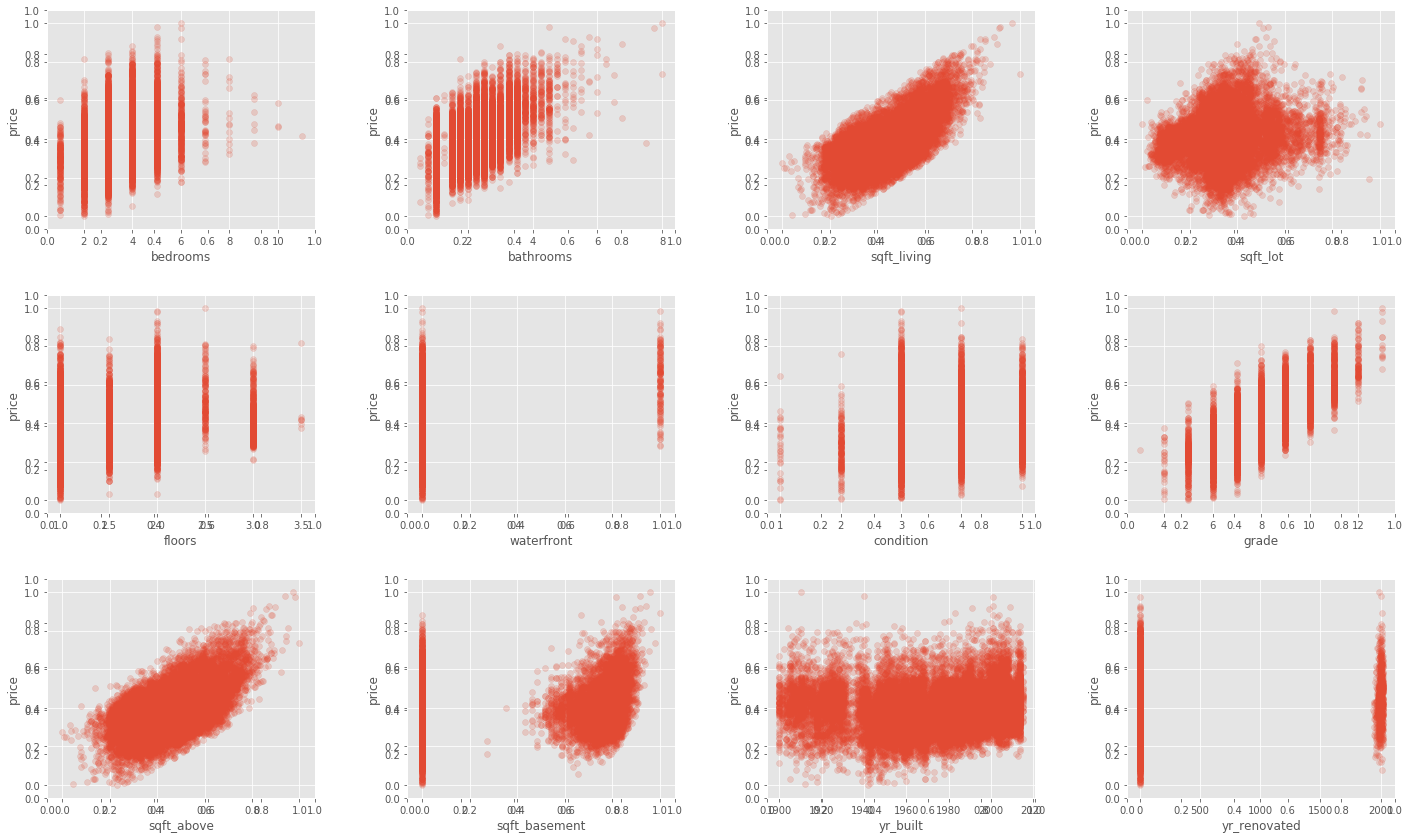

Feature selection method: <function stepwise_selection at 0x1c1a6809d8>


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


stepwise_selection: Add  floors_e1__2i                  with p-value 0.0
stepwise_selection: Add  grade_e10__11i                 with p-value 0.0
stepwise_selection: Add  grade_e6__7i                   with p-value 0.0
stepwise_selection: Add  sqft_above                     with p-value 0.0
stepwise_selection: Add  sqft_basement                  with p-value 0.0
stepwise_selection: Drop floors_e1__2i                  with p-value 0.0529718
stepwise_selection: Add  grade_e9__10i                  with p-value 4.29004e-150
stepwise_selection: Add  grade_e5__6i                   with p-value 2.29099e-165
stepwise_selection: Add  yr_built_e1920__1930i          with p-value 2.44836e-156
stepwise_selection: Add  grade_e8__9i                   with p-value 8.16461e-144
stepwise_selection: Add  yr_built_e1900__1910i          with p-value 1.5498e-141
stepwise_selection: Add  grade_e11__12i                 with p-value 4.29417e-142
stepwise_selection: Add  yr_built_e1910__1920i          with p-va

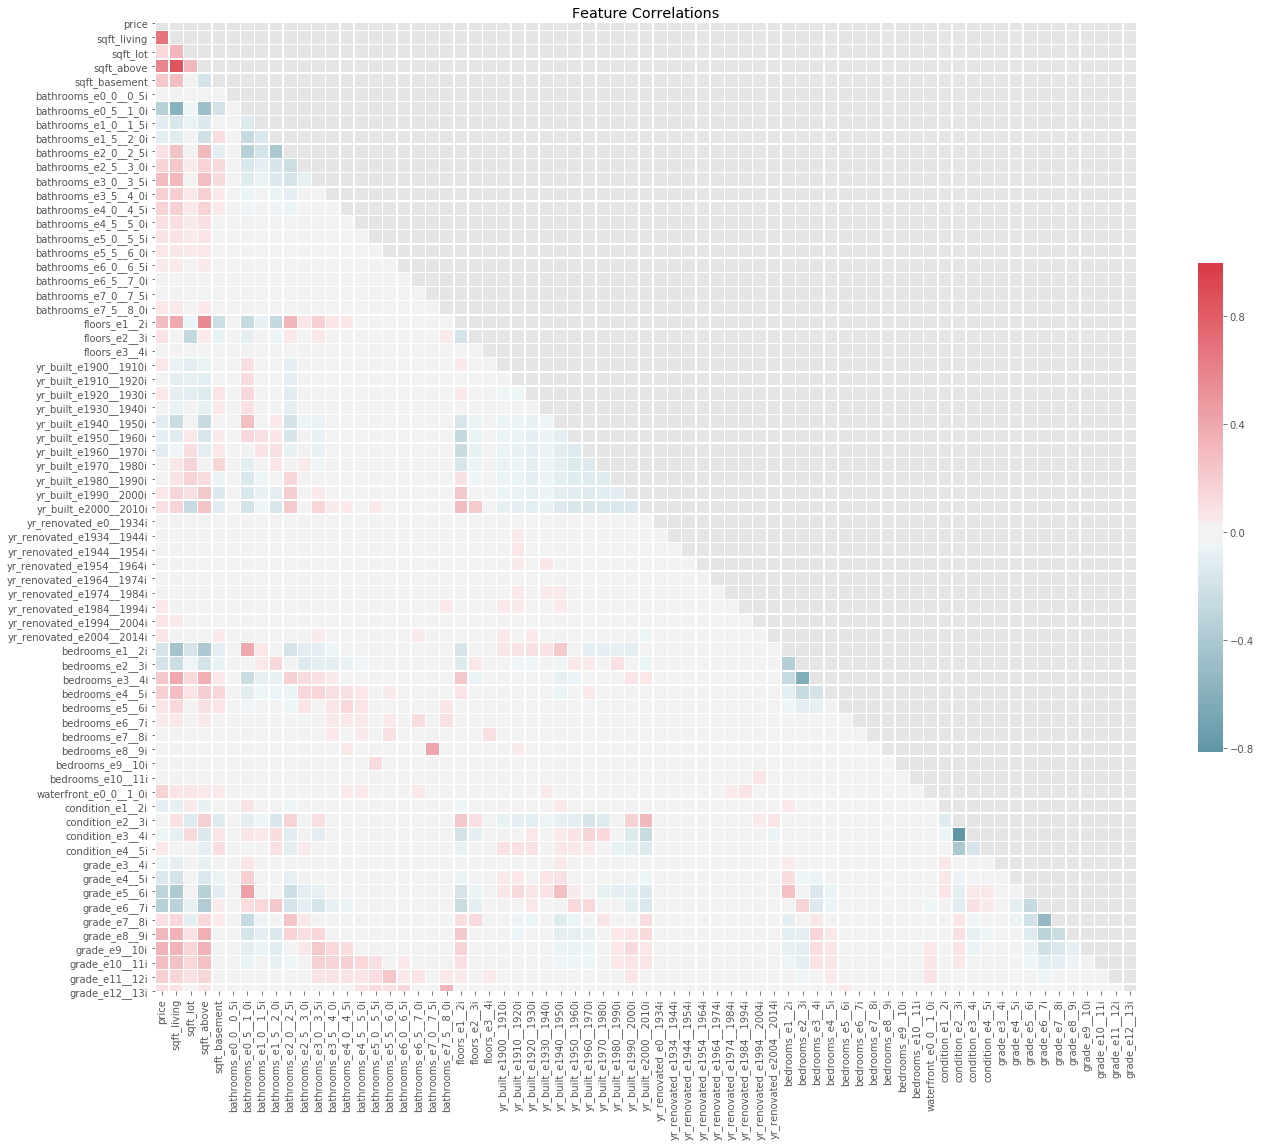

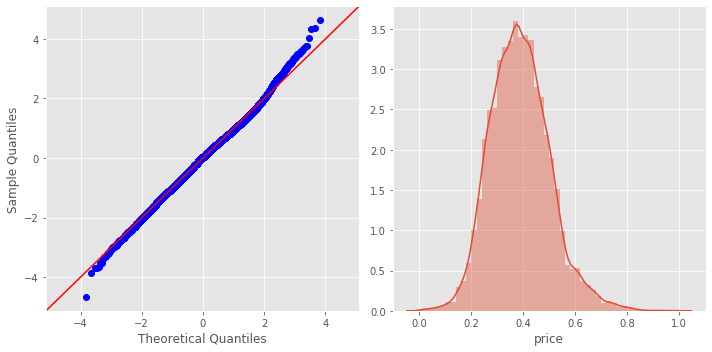

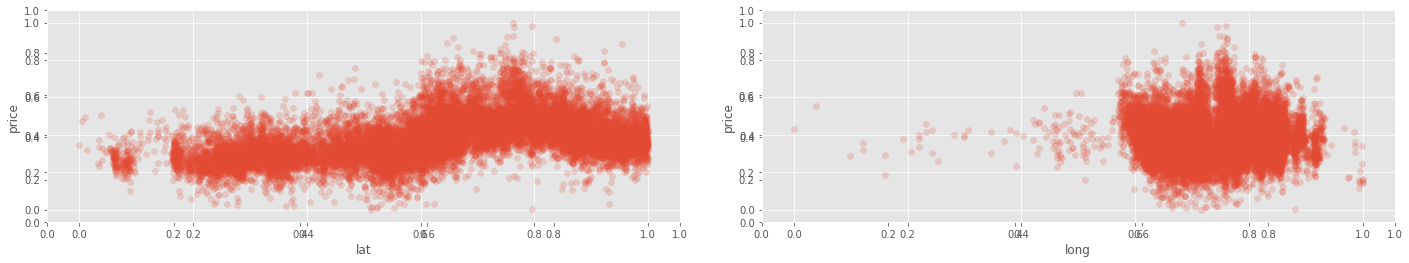

Feature selection method: <function stepwise_selection at 0x1c1a6809d8>
stepwise_selection: Add  lat                            with p-value 0.0
stepwise_selection: Add  long                           with p-value 5.53157e-65

stepwise_selection: starting features:
['lat', 'long']

stepwise_selection: selected features:
['lat', 'long']

stepwise_selection: dropped statistically insignificant features:
[]

formula: price~lat+long


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


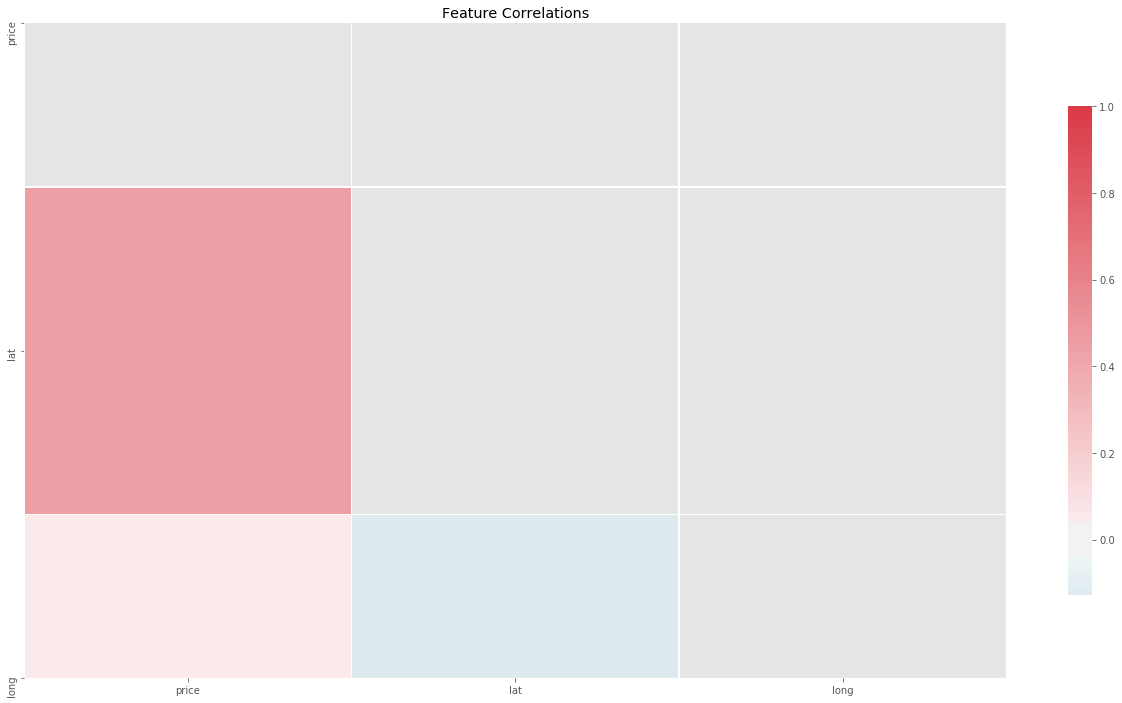

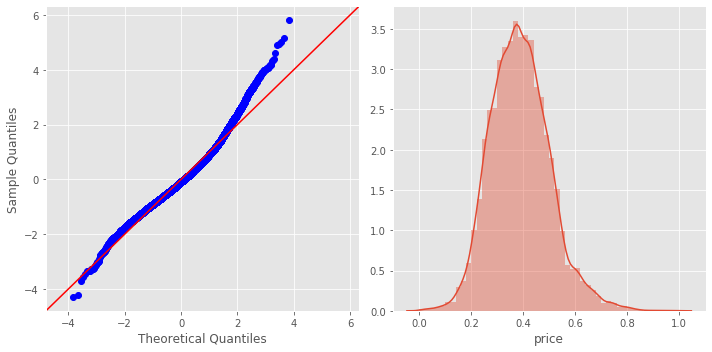

In [46]:
mv_r_sq_th = 0.60 # let's be a little more forgiving with our Coefficient of Determination since we are dealing with a reduced feature set

structural_features = [
    'bedrooms'
    , 'bathrooms'
    , 'sqft_living'
    , 'sqft_lot'
    , 'floors'
    , 'waterfront'
    , 'condition'
    , 'grade'
    , 'sqft_above'
    , 'sqft_basement'
    , 'yr_built'
    , 'yr_renovated'
]

(structural_features, neg_mse, to_drop) = scjpnregression.cv_selection(
    kchd_transformed_and_scaled_df.drop(target, axis=1)[structural_features]
    , kchd_transformed_and_scaled_df[[target]]
    , tr=tr
    , folds=10
    , scoring_method="neg_mean_squared_error"
    , fn_better_score=lambda neg_mse, best_neg_mse: abs(neg_mse) < abs(best_neg_mse)
)

kchd_structural_df = pd.concat(
    [
        kchd_transformed_and_scaled_df[[target]]
        , kchd_transformed_and_scaled_df[structural_features]
    ]
    , axis=1
    , join='inner'
)
(
    sel_features
    , model_fit_results
    , train_mse
    , test_mse
    , good_vif_features
    , bad_vif_features
    , kchd_structural_categorized_df
) = scjpnregression.run_full_regression_experiment(
    kchd_structural_df
    , target
    , to_drop=[]
    , tr=tr
    , mv_r_sq_th=mv_r_sq_th
    , mv_mse_delta_th=mv_mse_delta_th
    , mv_bad_vif_ratio_th=mv_bad_vif_ratio_th
    , p_cat=p_cat
    , fn_init_bin_bases=my_init_bin_bases
    , title="Full Regression Experiment, Question 1: Structural Features"
)
structural_sel_features = sel_features
structural_good_vif_features = good_vif_features
structural_bad_vif_features = bad_vif_features
structural_rsquared = model_fit_results.rsquared
structural_train_mse = train_mse
structural_test_mse = test_mse
#summarize_multicolinearity(kchd_structural_df, target, corr_filter_threshold=model_fit_results.rsquared)

location_features = ['lat', 'long']
kchd_location_df = pd.concat(
    [
        kchd_transformed_and_scaled_df[[target]]
        , kchd_transformed_and_scaled_df[location_features]
    ]
    , axis=1
    , join='inner'
)
(
    sel_features
    , model_fit_results
    , train_mse
    , test_mse
    , good_vif_features
    , bad_vif_features
    , kchd_location_categorized_df
) = scjpnregression.run_full_regression_experiment(
    kchd_location_df
    , target
    , to_drop=[]
    , tr=tr
    , mv_r_sq_th=mv_r_sq_th
    , mv_mse_delta_th=mv_mse_delta_th
    , mv_bad_vif_ratio_th=mv_bad_vif_ratio_th
    , p_cat=p_cat
    , fn_init_bin_bases=my_init_bin_bases
    , title="Full Regression Experiment, Question 1: Location Features"
)
location_sel_features = sel_features
location_good_vif_features = good_vif_features
location_bad_vif_features = bad_vif_features
location_rsquared = model_fit_results.rsquared
location_train_mse = train_mse
location_test_mse = test_mse

### Step 5: Question 1: *As a whole, do structural features or does location influence home sale price more?*: Analysis

In [47]:
display(HTML("The QQ plot of our regresssion model of <b>structural</b> features is outstanding!<br><b>$R^2 = {}$ of our model using structural features is decent</b>.<br><br>".format(round(structural_rsquared, 3))))
display(HTML("The QQ plot of our regresssion model of <b>location</b> features is decent.<br><b>$R^2 = {}$ of our model using location features is dismal</b>.<br><br>".format(round(location_rsquared, 3))))
display(
    HTML(
        "<b>The difference between MSE of our train/test partitions for both models is still very, very low at approximately ${}$ and ${}$, respectively.</b>".format(
            int(abs(structural_train_mse-structural_test_mse))
        , int(abs(location_train_mse-location_test_mse)))
    )
)
display(
    HTML(
        "Finally, <b>the bad VIF ratios - that is, measures of multicolinearity - are {}% and {}%, respectively</b>".format(
            round((len(structural_bad_vif_features)/len(structural_sel_features))*100, 2)
            , round((len(location_bad_vif_features)/len(location_sel_features))*100, 2)
        )
    )
)

Since conditions 2 and 3 have passed for both models, we can have confidence in the *Coefficient of Determination*, $R^2$, of each, respectively.

In [48]:
display(HTML("<h2>CONCLUSION:</h2>"))
more_influential_feature_set = ""
more_influential_feature_set_probability = 0
less_influential_feature_set = ""
less_influential_feature_set_probability = 0
equal = False
equal_probability = 0
if structural_rsquared > location_rsquared:
    more_influential_feature_set = "structural"
    more_influential_feature_set_probability = round(structural_rsquared*100, 2)
    less_influential_feature_set = "location"
    less_influential_feature_set_probability = round(location_rsquared*100, 2)
elif location_rsquared > structural_rsquared:
    more_influential_feature_set = "location"
    more_influential_feature_set_probability = round(location_rsquared*100, 2)
    less_influential_feature_set = "structural"
    less_influential_feature_set_probability = round(structural_rsquared*100, 2)
else:
    equal = True
    equal_probability = round(structural_rsquared,2) # pick one or the other
display(
    HTML(
        "<h3>As a whole, based on the relative measures of the <i>Coefficients of Determinination</i> of <i>price</i>, we can say that <b>{}</b>.</h3>".format(
            "structural and location feature sets <i>equally</i> influence the sale price of homes in King's County" if equal 
            else 
                "<i>{}</i> features influence the sale price of homes in King's County more than <i>{}</i> features do.".format(
                    more_influential_feature_set
                    , less_influential_feature_set
                )
        )
    )
)

To get an intuitive feel that location does not much influence (very low $R^2!$) the sale price of homes in King's County, let's plot a heat map of sale price by location $(lat, long)$.  

### Explanation:
**Let's be clear about what we are asking, here**.  

**If there were some *linear* relationship between $price \sim (lat, long)$ then this means we should expect to see the sale price of a home increase as the coordinates of $(lat, long)$ do**.  How weird would that be?!

Clearly, this doesn't make sense.  **Intuitively, we understand that increasing sale price of a home most certainly is NOT determined by increasing $(lat, long)$**.  **It is then obvious that there is a problem in the *way* that we have asked that question**.

Let's take a look at the a heatmap of home sales, wherein a location "grows hotter" in the heatmap by increasing price.

The function below uses the ***folium* library for Python**  to build/display the heatmap.  Credit goes to Sivji (2017) as the original author of this function.  Of course, I have heavily modified it to suit my purposes.

In [49]:
scjpnutils.map_points(
    kchd_df
    , plot_points=False
    , draw_heatmap=True
    , heat_map_weights_normalize=False
    , heat_map_weights_col='price'
    , heat_map_radius=8
    , zoom_start=9
)

**Clearly there is *SOME* relationship between $price \sim (lat, long)$, otherwise we would not see the clustering effect that we do** - i.e. we see regions of clustering/increasing "heat", indicating similar-priced home are grouped together in regions.  

**But that relationship is is certainly not *linear*** in nature... at least, **price** is not linearly related to $(lat, long)$.

For now, if we wanted to move forward with this, with the intent of predicting price based on $(lat, long)$, we could obviously create a mapping of region - perhaps some bounding box defined by $((lat, long)_{top\_left}, (lat, long)_{bottom\_right})$, for example.  This mapping would allows us to then "look" up home prices by $(lat, long)$.

BUT, my guess is that we would find that, given a fixed price range - i.e. the amount of "heat" above - we would find a similar set of structural features with very low probability.  In other words, the clustering in sale price of homes doesn't have much to do with common sets of structural features of neighbors.

### What's the bottom line?
**What really matters, mostly, in the end, in determining *price* is the set of structural features a given home has when looking at relationships established between $price \sim structural\_features)$ vs. $price \sim (lat, long)$ *from a linear regression perspective***.  Note that **we are NOT saying that, in general, *structural features* determine *price* more than *location* does** - to the contrary!  But what we are saying is that **linear regression is not enough to determine this in general**.

We can clearly see this since **the model using *structural* features as independents manifests kurtosis that is beautifully mesokurtic**.

**The kurtosis manifested in the $(lat, long)$ model isn't bad, per se, but the Coefficient of Determination, $R^2$, is basically worthless**.

But didn't we say this from the beginning?  Yes and no.  The conclusion was correct but was applied to the wrong semantic version of "location" within the context of our original question.  As it turns out, it is postulated, that $(lat, long)$ more or less simply references, or is equivalent to, a likely common set of structural features.

Having said that, what are the most influential structural features impacting the sale price of a home?

### Step 5: Question 2: Which structrual features affect the value of a home the most?

In this case, we want to restrict our investigation to features that are "truly" structural in nature.

According to the definitions of the features, **grade** is an evaluation of the home as a whole and is largely dependent on structural features of the home; therefore, we will exclude this feature from consideration.

All other structural features that we examined earlier, then, are "truly" structural in nature.

Let's run another regression experiment on the structural features, excluding **grade** this time.

new best neg_mean_squared_error score: -0.011543470122085928, from feature-set combo: ['bedrooms']
new best neg_mean_squared_error score: -0.009162405878349916, from feature-set combo: ['bathrooms']
new best neg_mean_squared_error score: -0.007163637952252564, from feature-set combo: ['sqft_living']


new best neg_mean_squared_error score: -0.007024742947120337, from feature-set combo: ['bedrooms', 'sqft_living']
new best neg_mean_squared_error score: -0.006982112160963292, from feature-set combo: ['sqft_living', 'waterfront']
new best neg_mean_squared_error score: -0.006866536237544527, from feature-set combo: ['sqft_living', 'yr_built']


new best neg_mean_squared_error score: -0.006863451950861949, from feature-set combo: ['bedrooms', 'sqft_living', 'waterfront']
new best neg_mean_squared_error score: -0.006683541839388381, from feature-set combo: ['bedrooms', 'sqft_living', 'yr_built']
new best neg_mean_squared_error score: -0.006617490800157046, from feature-set combo: ['bathrooms', 'sqft_living', 'yr_built']
new best neg_mean_squared_error score: -0.006540248330287624, from feature-set combo: ['sqft_living', 'floors', 'yr_built']


new best neg_mean_squared_error score: -0.006370575773882096, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'yr_built']


new best neg_mean_squared_error score: -0.006261535544392885, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'yr_built']
new best neg_mean_squared_error score: -0.006191905015453041, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'yr_built']


new best neg_mean_squared_error score: -0.006153523150986363, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'yr_built']
new best neg_mean_squared_error score: -0.006131901439169685, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'yr_built']
new best neg_mean_squared_error score: -0.0060761870372601934, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'yr_built']


new best neg_mean_squared_error score: -0.006029279740931652, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'yr_built']


new best neg_mean_squared_error score: -0.00601599134365309, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'yr_built']
new best neg_mean_squared_error score: -0.005999380489441895, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'sqft_above', 'sqft_basement', 'yr_built']


new best neg_mean_squared_error score: -0.0059586636721910054, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'sqft_above', 'sqft_basement', 'yr_built']


new best neg_mean_squared_error score: -0.005939098882706257, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'sqft_above', 'sqft_basement', 'yr_built']


new best neg_mean_squared_error score: -0.005938417031689099, from feature-set combo: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']


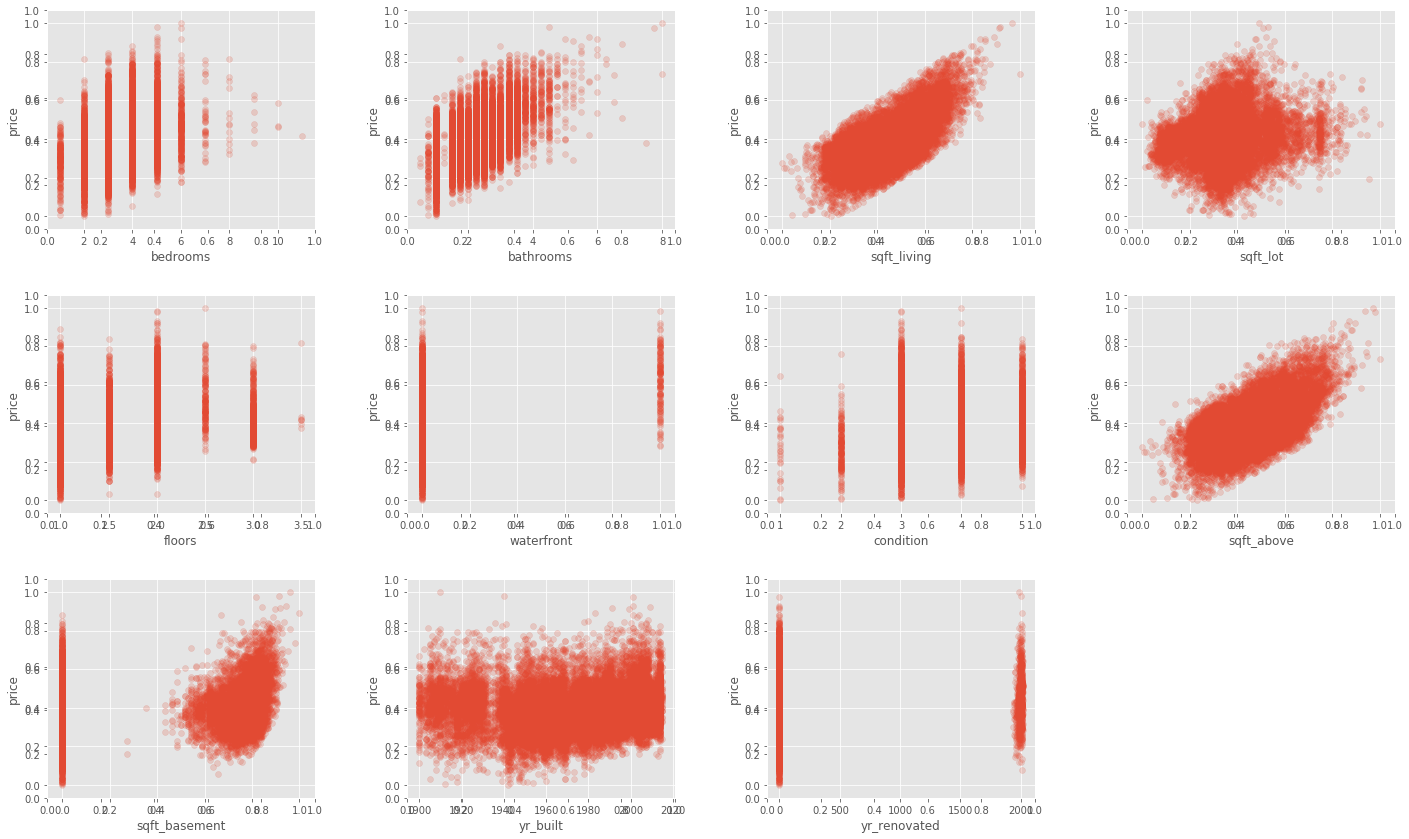

Feature selection method: <function stepwise_selection at 0x1c1a6809d8>


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


stepwise_selection: Add  floors_e1__2i                  with p-value 0.0
stepwise_selection: Add  sqft_basement                  with p-value 0.0
stepwise_selection: Add  sqft_living                    with p-value 0.0
stepwise_selection: Add  bedrooms_e1__2i                with p-value 6.33079e-142
stepwise_selection: Add  waterfront_e0_0__1_0i          with p-value 8.33094e-112
stepwise_selection: Add  yr_built_e1920__1930i          with p-value 1.07026e-103
stepwise_selection: Add  yr_built_e1900__1910i          with p-value 2.59401e-103
stepwise_selection: Add  floors_e2__3i                  with p-value 3.98024e-95
stepwise_selection: Add  sqft_above                     with p-value 3.81228e-67
stepwise_selection: Add  yr_built_e1910__1920i          with p-value 7.95037e-62
stepwise_selection: Drop floors_e1__2i                  with p-value 0.586586
stepwise_selection: Add  yr_built_e1940__1950i          with p-value 4.2237e-48
stepwise_selection: Add  yr_built_e1930__1940i      

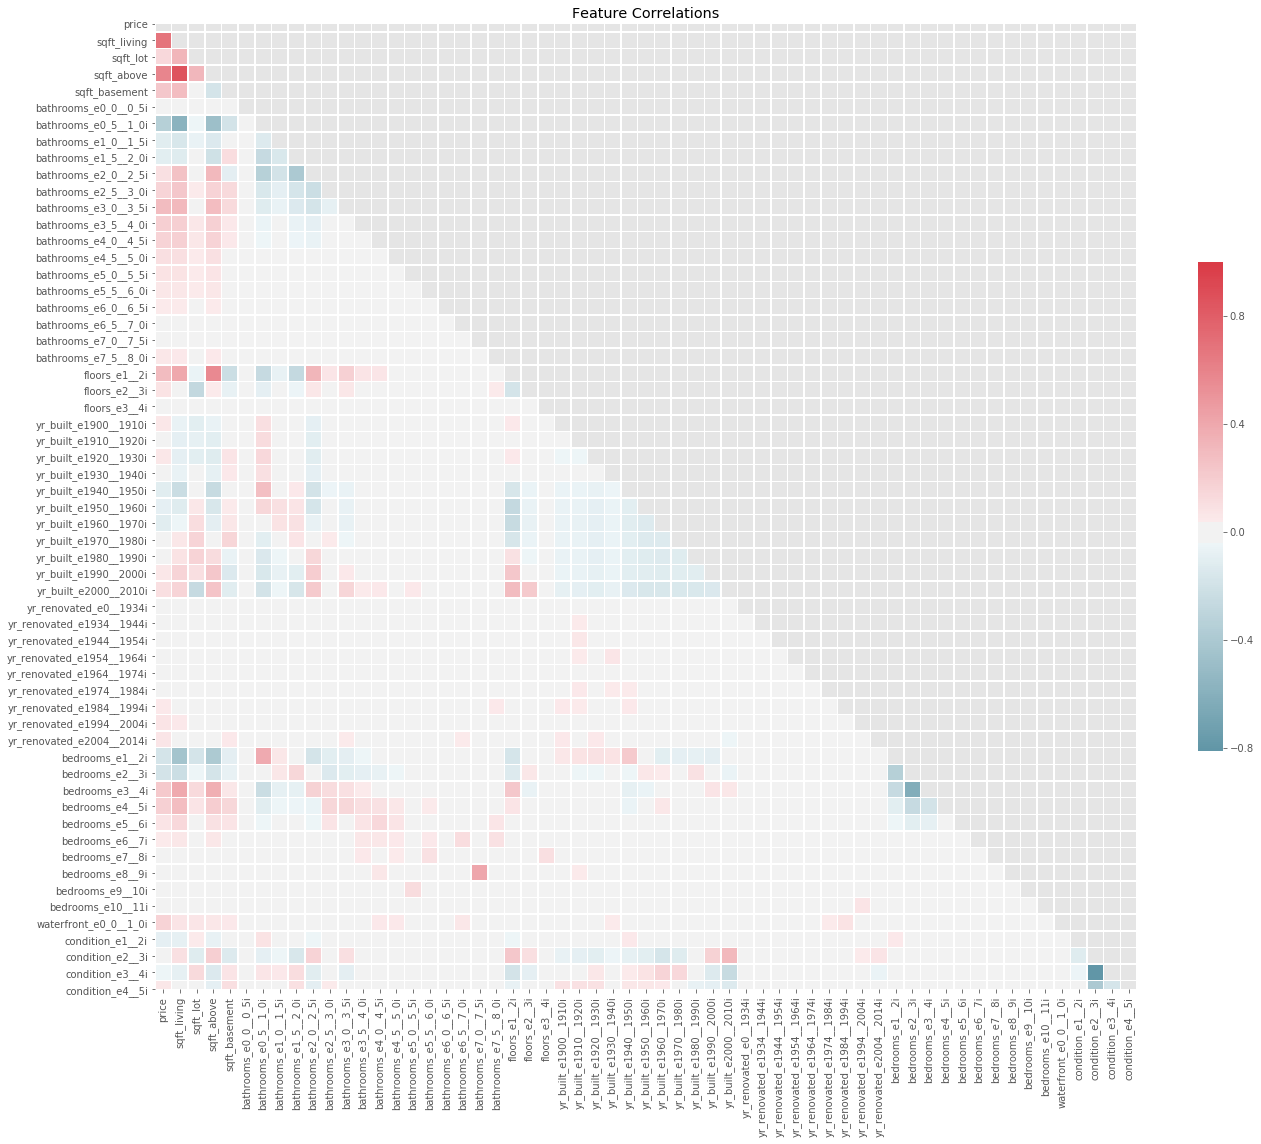

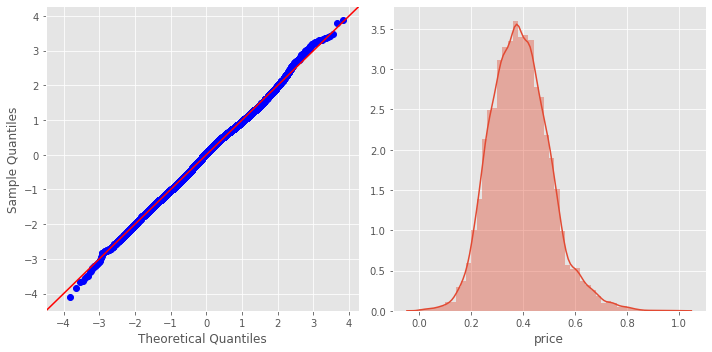

In [50]:
tr = 0.30
mv_r_sq_th = 0.55

structural_features = [
    'bedrooms'
    , 'bathrooms'
    , 'sqft_living'
    , 'sqft_lot'
    , 'floors'
    , 'waterfront'
    , 'condition'
    , 'sqft_above'
    , 'sqft_basement'
    , 'yr_built'
    , 'yr_renovated'
]

(structural_features, neg_mse, to_drop) = scjpnregression.cv_selection(
    kchd_transformed_and_scaled_df.drop(target, axis=1)[structural_features]
    , kchd_transformed_and_scaled_df[[target]]
    , tr=tr
    , folds=10
    , scoring_method="neg_mean_squared_error"
    , fn_better_score=lambda neg_mse, best_neg_mse: abs(neg_mse) < abs(best_neg_mse)
)

kchd_structural_df = pd.concat(
    [
        kchd_transformed_and_scaled_df[[target]]
     , kchd_transformed_and_scaled_df[structural_features]
    ]
    , axis=1
    , join='inner'
)

(
    sel_features
    , model_fit_results
    , train_mse
    , test_mse
    , good_vif_features
    , bad_vif_features
    , kchd_structural_categorized_df
) = scjpnregression.run_full_regression_experiment(
    kchd_structural_df
    , target
    , to_drop=[]
    , tr=tr
    , mv_r_sq_th=mv_r_sq_th
    , mv_mse_delta_th=mv_mse_delta_th
    , mv_bad_vif_ratio_th=mv_bad_vif_ratio_th
    , p_cat=p_cat
    , fn_init_bin_bases=my_init_bin_bases
    , title="Full Regression Experiment, Question 2: \"True\" Structural Features"
)
structural_sel_features = sel_features
structural_good_vif_features = good_vif_features
structural_bad_vif_features = bad_vif_features
structural_rsquared = model_fit_results.rsquared
structural_train_mse = train_mse
structural_test_mse = test_mse

## Conclusion:

The kurtosis manifested, by virtue of its QQ-plot, in this model is simply amazing!  The set of "true" structural features boasts a distribution in price that is fully mesokurtic with nominal outliers.

But since categorical features have been categorized, assessing which (categorical) features, ***prior* to categorization**, are the "most" influential is not straightforward.  So we simply judge each *binned* categorical feature as is.

We can judge how influential a feature is by virtue of its *p-value*.

Since muticolinearity is virtually non-existent, we have high confidence in the *p-value* of each feature.

Therefore, we can list the most influential features in determing **price** in this model simply by ordering the "GOOD" VIF features by increasing *p-value*.

They have already been listed in the output of our regression results but we list them again here, in decreasing order of influence - i.e. those listed first are the "most" influential in determing price and decrease in importance as we go down the list:

In [51]:
s_html = "<ol>"
for structural_good_vif_feature in structural_good_vif_features:
    s_html += "<li>{}</li>".format(structural_good_vif_feature)
s_html += "</ol>"
display(HTML(s_html))

### Step 5: Bonus Question: What if we make some invalid assumptions about features? How can we use our tools to detect this?

Suppose, during the EDA phase, in examining the **y_built** and **yr_renovated** features, I surmised that these features are not, in fact, *categorical*.  Futher, suppose I surmise that new, *ephemoral*, *continuous* features can be derived from their values to indicate *elapsed time* of each.

Then, for:
1. **yr_built**, the *elapsed time* (in years) from **yr_built** until *today's date* represents the **age** of the home in years
2. **yr_renovated**, the *elapsed time* (in years) from **yr_renovated** until *today's date* represents the home's **yrs_since_renovated** (*if* **yr_renovated** $> 0$)

Clearly these are *continuous* (quantitative) values.  The (hypothetical) motivation in doing this is to derive higher fidelity in predicting the target, **price**.

So far, the logic seems sound.

BUT! There is a hidden "gotcha".  Can you spot it?

Okay time's up.

The answer lies in the *ephemoral* or *temporal* nature of these derived values.  These values would be computed at the time the regression is run.  Still don't see why this is a problem?  The final answer is that these values change!  All other data already in the data set remains fixed in time.

Okay.  Now that we have an understanding *beforehand* of the problem we might wonder, can any of these tools currently at our disposal detect that this is problematic assuming we didn't spot this up front?

Let's see.

But first, we must frame this problem in code.

The formula for **age** is: $age=today(year)-yr\_built$.

The formula for **yrs_since_renovated** is: $age=0\ if\ yr\_renovated=0\ else\ today(year)-yr\_renovated$.

In [52]:
from datetime import date

dt_today = date.today()

kchd_transformed_and_scaled_with_ephemoral_df = kchd_transformed_and_scaled_df.copy()
kchd_transformed_and_scaled_with_ephemoral_df['age'] = dt_today.year - kchd_transformed_and_scaled_with_ephemoral_df['yr_built']
kchd_transformed_and_scaled_with_ephemoral_df['yrs_since_renovated'] = 0
kchd_transformed_and_scaled_with_ephemoral_df.loc[
    kchd_transformed_and_scaled_with_ephemoral_df['yr_renovated']!=0
    , ['yrs_since_renovated']
] = dt_today.year - kchd_transformed_and_scaled_with_ephemoral_df['yr_renovated']

scjpnutils.print_df_head(kchd_transformed_and_scaled_with_ephemoral_df[['yr_built', 'age', 'yr_renovated', 'yrs_since_renovated']])

Now suppose, being the good data scientists we are - albet evidently prone to the occasional but forgiveable misconception - that we do not forget to log-transform these values:

In [53]:
to_be_lt_transformed_and_scaled = ['age', 'yrs_since_renovated']

# first must replace 0 with 1 to make log-transformation possible!
for lt_cont_feature in to_be_lt_transformed_and_scaled:
    scjpnutils.clean_offending_values(
        kchd_transformed_and_scaled_with_ephemoral_df
        , numeric_replacement_rules=
            {
                lt_cont_feature: [(0.0, 1)]
            }
        , friendly_name_of_df="King County House Sales DF"
    )

# now to log-transformation, then min-max scaling
kchd_transformed_and_scaled_with_ephemoral_df = scjpnutils.min_max_scaling(
    scjpnutils.log_transform(kchd_transformed_and_scaled_with_ephemoral_df, to_be_lt_transformed_and_scaled)
    , to_be_lt_transformed_and_scaled
)
kchd_transformed_and_scaled_with_ephemoral_df[['age', 'yrs_since_renovated']].describe().loc[['min', 'max']]

*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'age' column value replacement are: [(0.0, 1)]
Looking for rows with 'age' values [0.0] ...
There are no rows that contain values of 'age' in [0.0]!
*** CLEANING VALUES of King County House Sales DF: END ***
*** CLEANING VALUES of King County House Sales DF: BEGIN ***

Rules for 'yrs_since_renovated' column value replacement are: [(0.0, 1)]
Looking for rows with 'yrs_since_renovated' values [0.0] ...
Rows with offending values occur at Int64Index([    0,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            21587, 21588, 21589, 21590, 21591, 21592, 21593, 21594, 21595,
            21596],
           dtype='int64', length=20853).
Replaced 20853 offending instances in column 'yrs_since_renovated' with literal value 1

*** CLEANING VALUES of King County House Sales DF: END ***


age  yrs_since_renovated
min  0.0                  0.0
max  1.0                  1.0

So far, so good.  Now, being the careful data scientists we strive to be, we drop **yr_built** and **yr_renovated** just to be sure it doesn't accidentally make it into our model:

In [54]:
kchd_transformed_and_scaled_with_ephemoral_df.drop(['yr_built', 'yr_renovated'], axis=1, inplace=True)

scjpnutils.print_df_head(kchd_transformed_and_scaled_with_ephemoral_df)

Now let's run `split_categorical` to get our initial list of *continuous* vs. *categorical* features.

Note that there is a bit of irony incoming here, since **this function will "classify" both *age* and *yrs_since_renovated* as *categorical***!

Normally, this would be our first clue of our misstep but, for the sake of argument, let's look over this hint that our tools provide early on.

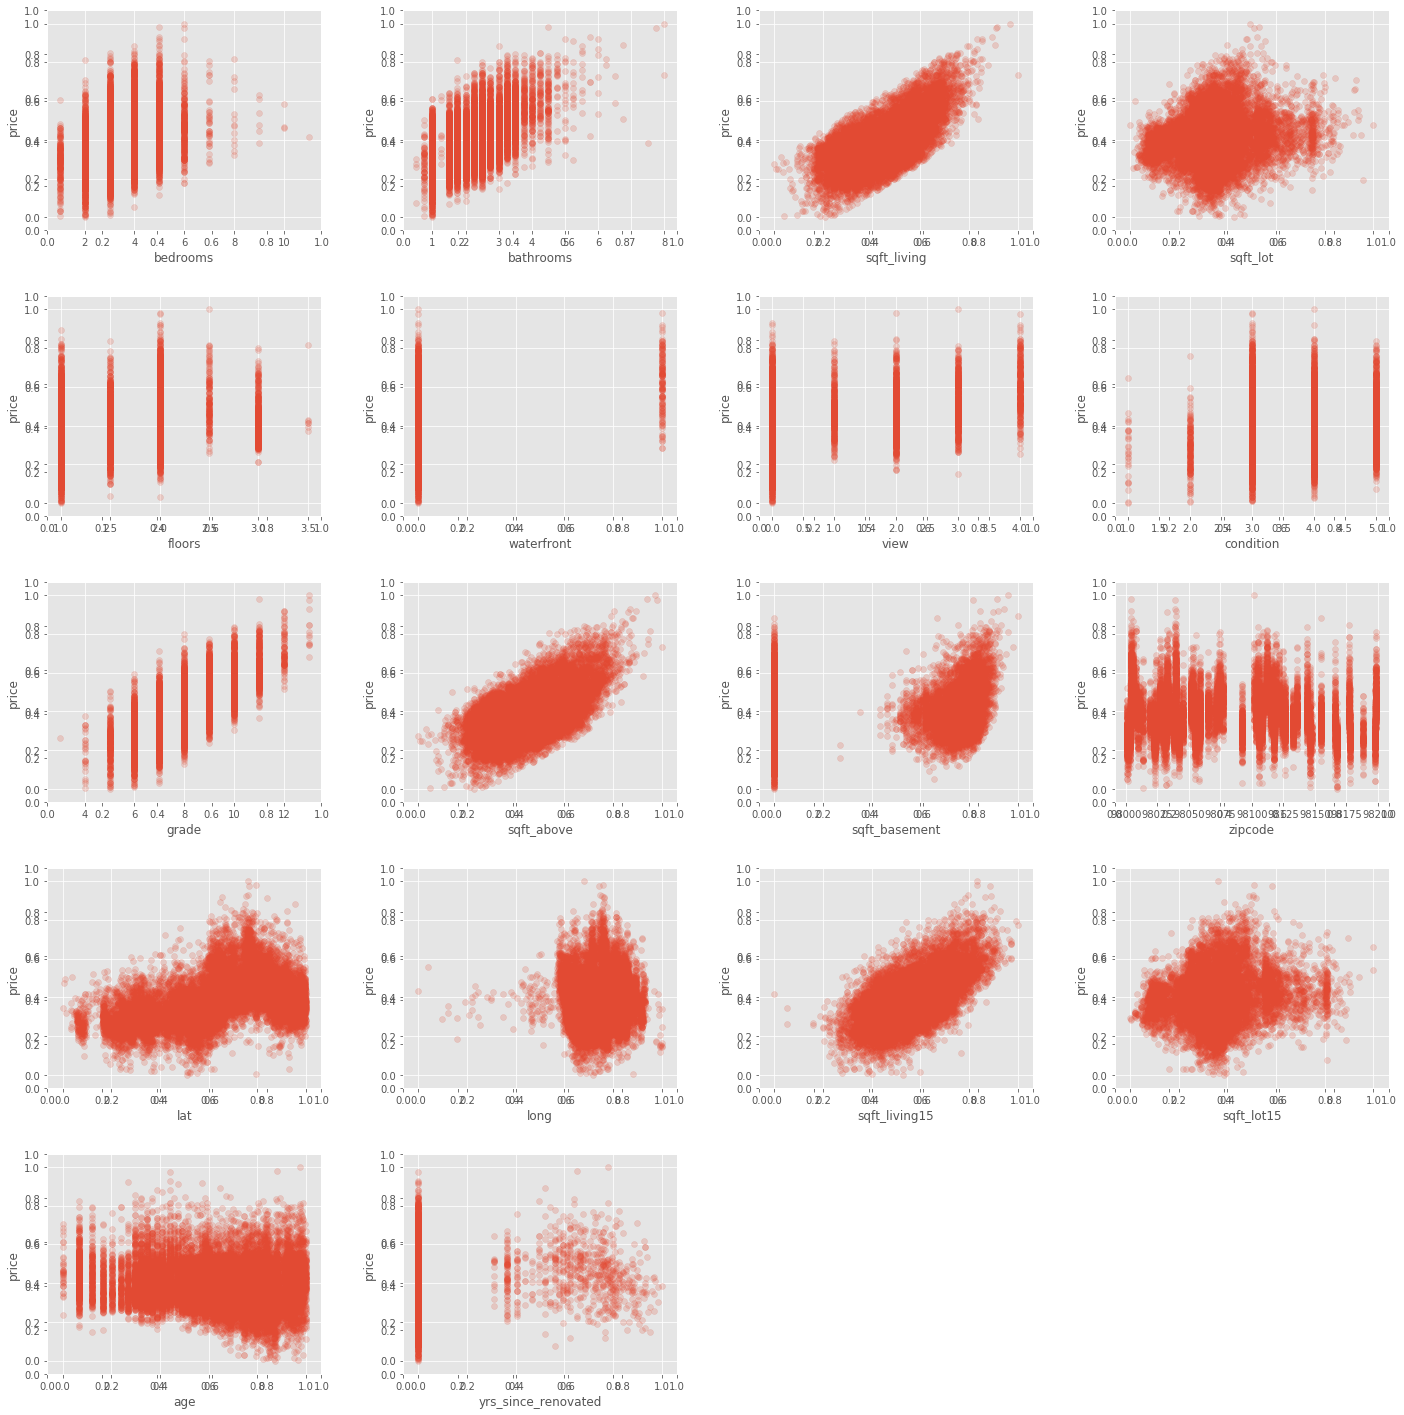

In [55]:
(
    _
    , categorical_features
    , continuous_features
) = scjpnregression.split_categorical(kchd_transformed_and_scaled_with_ephemoral_df, p_cat, target)

As expected, the `split_categorical` function reports that both **age** and **yrs_since_renovated** are *categorical* with $p\_cat=0.9946$ and $p\_cat=0.9968$ (greater than 99% probability!), respectively.
 
Again, let's assume we look over this important hint that our tools provide... so we override and set both **age** and **yrs_since_renovated** as *continuous* features manually:

In [56]:
continuous_features = [
    'sqft_living'
    , 'sqft_lot'
    , 'sqft_above'
    , 'sqft_basement'
    , 'lat'
    , 'long'
    , 'sqft_living15'
    , 'sqft_lot15'
    , 'age'
    , 'yrs_since_renovated'
]

categorical_features = list(kchd_transformed_and_scaled_with_ephemoral_df.drop(target, axis=1).columns)
for continuous_feature in continuous_features:
    categorical_features.remove(continuous_feature)
    
print("continuous_features:\n{}".format(continuous_features))
print("categorical_features:\n{}".format(categorical_features))

continuous_features:
['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'age', 'yrs_since_renovated']
categorical_features:
['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'zipcode']


Looks great (although, ultimately, flawed!).

Let's run regression and behold the results of our amazing model-to-be!

But first, let's again use *cross-validation* to validate that our entire set of *continuous* features best predicts our target, **price**:

In [57]:
(continuous_features, neg_mse, to_drop) = scjpnregression.cv_selection(
    kchd_transformed_and_scaled_with_ephemoral_df.drop(target, axis=1)[continuous_features]
    , kchd_transformed_and_scaled_with_ephemoral_df[[target]]
    , tr=tr
    , folds=10
    , scoring_method="neg_mean_squared_error"
    , fn_better_score=lambda neg_mse, best_neg_mse: abs(neg_mse) < abs(best_neg_mse)
)

new best neg_mean_squared_error score: -0.007163637952252564, from feature-set combo: ['sqft_living']


new best neg_mean_squared_error score: -0.007065793117677431, from feature-set combo: ['sqft_living', 'sqft_lot']
new best neg_mean_squared_error score: -0.004808061244411213, from feature-set combo: ['sqft_living', 'lat']


new best neg_mean_squared_error score: -0.004805999107110641, from feature-set combo: ['sqft_living', 'sqft_lot', 'lat']
new best neg_mean_squared_error score: -0.004776878830277335, from feature-set combo: ['sqft_living', 'sqft_above', 'lat']
new best neg_mean_squared_error score: -0.004723211111781487, from feature-set combo: ['sqft_living', 'lat', 'long']
new best neg_mean_squared_error score: -0.0045372155254775545, from feature-set combo: ['sqft_living', 'lat', 'sqft_living15']


new best neg_mean_squared_error score: -0.00451175205115288, from feature-set combo: ['sqft_living', 'sqft_lot', 'lat', 'sqft_living15']
new best neg_mean_squared_error score: -0.00434524990378496, from feature-set combo: ['sqft_living', 'lat', 'long', 'sqft_living15']


new best neg_mean_squared_error score: -0.004341779957527432, from feature-set combo: ['sqft_living', 'sqft_lot', 'lat', 'long', 'sqft_living15']
new best neg_mean_squared_error score: -0.0043134046517058, from feature-set combo: ['sqft_living', 'sqft_above', 'lat', 'long', 'sqft_living15']
new best neg_mean_squared_error score: -0.004302742293493632, from feature-set combo: ['sqft_living', 'lat', 'long', 'sqft_living15', 'yrs_since_renovated']
new best neg_mean_squared_error score: -0.004276054547522795, from feature-set combo: ['sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15']


new best neg_mean_squared_error score: -0.004259778840790453, from feature-set combo: ['sqft_living', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15']
new best neg_mean_squared_error score: -0.004233605994906032, from feature-set combo: ['sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'yrs_since_renovated']


new best neg_mean_squared_error score: -0.004218034455592596, from feature-set combo: ['sqft_living', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'yrs_since_renovated']


new best neg_mean_squared_error score: -0.004216353803028901, from feature-set combo: ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'yrs_since_renovated']
new best neg_mean_squared_error score: -0.004212694883881254, from feature-set combo: ['sqft_living', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'yrs_since_renovated']


new best neg_mean_squared_error score: -0.004210310724734415, from feature-set combo: ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'yrs_since_renovated']


What the... ?!?!

Really?!  After going through all that effort to derive this great new, "continuous" feature, **age**, the `cv_selection` function has the gall to suggest dropping it?!

And here we reach the moral of the story.

We have seen that our tools have so kindly attempted to point out (multiple times, even) that we have made an error misclassifying *continuous* vs. *categorical features*.

**Final moral of the story**:

    Math works, people! That is, assuming you do it correctly.  So do your math!  Pay attention and do it correctly.  Listen to the results it gives.  And make the most of your tools!

We will go ahead now, out of sheer morbid curiosity, to conclude this exercise with the results we get if we run full regression based on this bad assumption.  It should serve as a nice parting thought!

Feature selection method: <function stepwise_selection at 0x1c1a6809d8>


/Users/stevencontreras/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


stepwise_selection: Add  floors_e1__2i                  with p-value 0.0
stepwise_selection: Add  grade_e10__11i                 with p-value 0.0
stepwise_selection: Add  grade_e6__7i                   with p-value 0.0
stepwise_selection: Add  sqft_above                     with p-value 0.0
stepwise_selection: Add  sqft_basement                  with p-value 0.0
stepwise_selection: Drop floors_e1__2i                  with p-value 0.0529718
stepwise_selection: Add  lat                            with p-value 0.0
stepwise_selection: Add  zipcode_e98003__98004i         with p-value 3.30961e-258
stepwise_selection: Add  view_e3_0__4_0i                with p-value 5.4446e-227
stepwise_selection: Add  sqft_living15                  with p-value 1.95235e-198
stepwise_selection: Add  long                           with p-value 1.29356e-162
stepwise_selection: Add  zipcode_e98039__98040i         with p-value 3.3169e-156
stepwise_selection: Add  zipcode_e98148__98155i         with p-value 2.9799

stepwise_selection: Add  bathrooms_e4_5__5_0i           with p-value 1.81977e-05
stepwise_selection: Add  bathrooms_e2_5__3_0i           with p-value 1.83595e-05
stepwise_selection: Add  bathrooms_e2_0__2_5i           with p-value 9.0082e-07
stepwise_selection: Add  bedrooms_e5__6i                with p-value 0.000123407
stepwise_selection: Add  bedrooms_e1__2i                with p-value 0.000256224
stepwise_selection: Add  bedrooms_e4__5i                with p-value 0.000346017
stepwise_selection: Add  zipcode_e98022__98023i         with p-value 0.000464853
stepwise_selection: Add  bathrooms_e5_0__5_5i           with p-value 0.000517414
stepwise_selection: Add  bathrooms_e6_0__6_5i           with p-value 0.00258566
stepwise_selection: Add  zipcode_e98045__98052i         with p-value 0.0038141
stepwise_selection: Drop zipcode_e98055__98056i         with p-value 0.0593682
stepwise_selection: Add  zipcode_e98072__98074i         with p-value 0.000242162
stepwise_selection: Drop zipcode_e

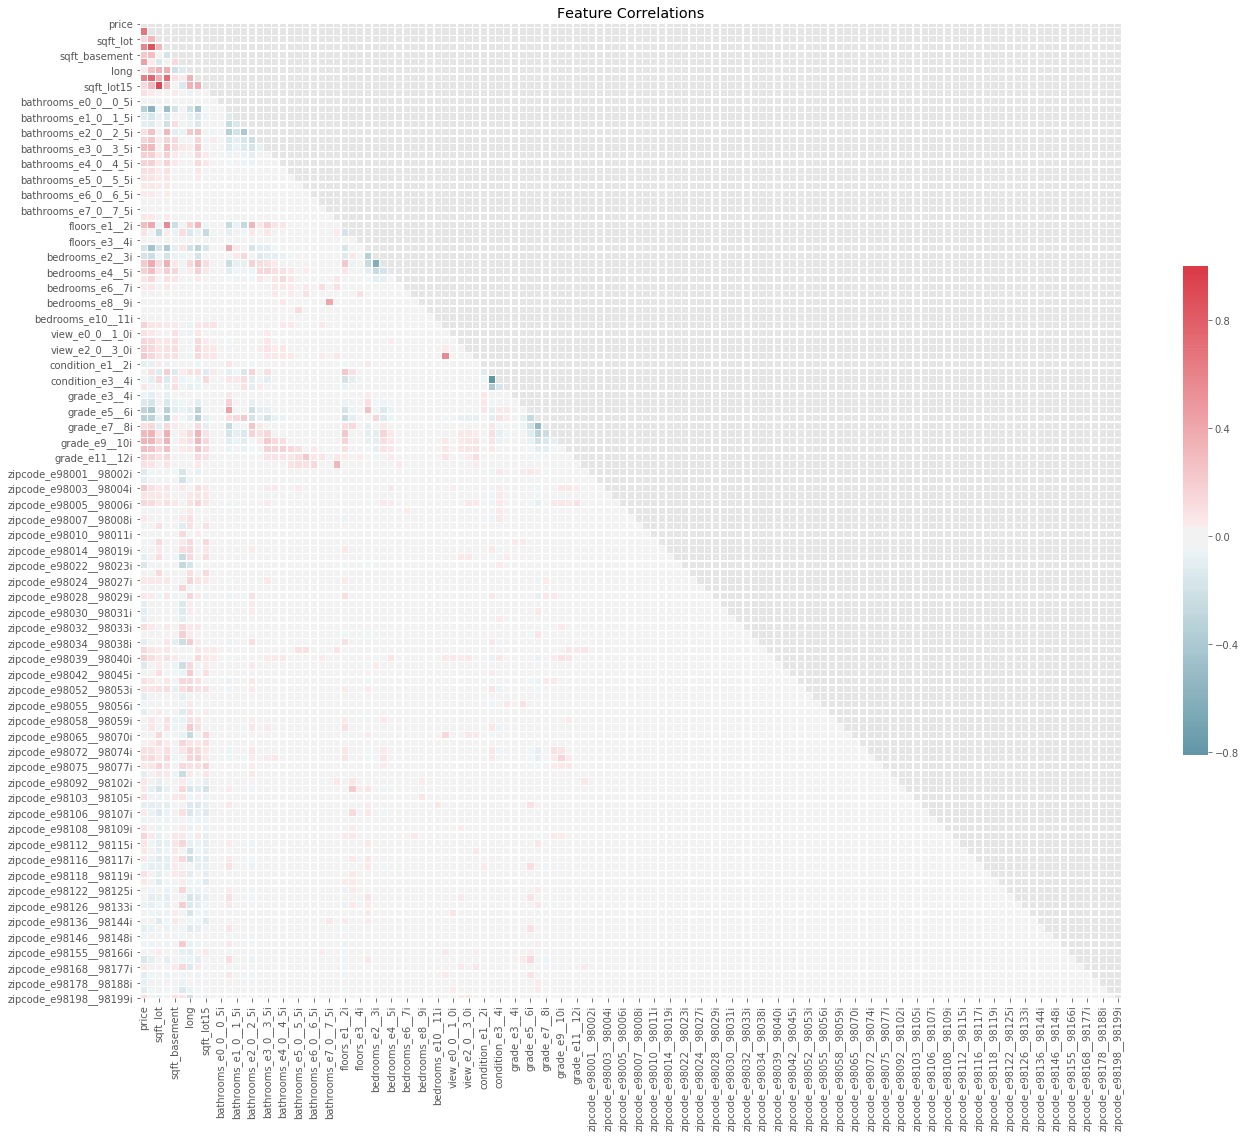

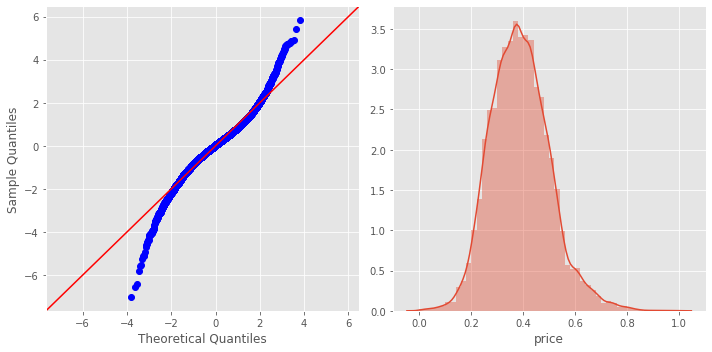

In [58]:
(
    sel_features
    , model_fit_results
    , train_mse
    , test_mse
    , good_vif_features
    , bad_vif_features
    , kchd_transformed_and_scaled_with_ephemoral_categorized_df
) = scjpnregression.run_full_regression_experiment(
    kchd_transformed_and_scaled_with_ephemoral_df
    , target
    , to_drop=[]
    , tr=tr
    , mv_r_sq_th=mv_r_sq_th
    , mv_mse_delta_th=mv_mse_delta_th
    , mv_bad_vif_ratio_th=mv_bad_vif_ratio_th
    , p_cat=p_cat
    , fn_init_bin_bases=my_init_bin_bases
    , cont_and_cat_features_tuple=(continuous_features, categorical_features)
    , title="Full Regression Experiment, Bonus Question"
)

### Closing thoughts: Bonus Question Regression Analysis

First, in spite of all that, the model is not horrible.  In fact, this is our highest $R^2$ yet!  But take a look at the kurtosis.  To say that it is platykurtic is a stretch.  This model has kurtosis right on the edge of being classified as leptokurtic.  Let's just call it what it is.  It's leptokurtic (but not as bad as our very first preliminary model's kurtosis).  This model is overfit!

The key take away, here is:
1. The extrememly high jump in $R^2$ should be looked upon with suspicion in any case.
2. `stepwise-selection`, for the first time in this study, found a fair amount of features that it considered statstically insignificant; granted, they're all bins of **zipcode**, which should make sense given our prior disucssion on *structural* vs. *location* features.
3. Instead of moving closer to mesokurtic kurtosis, we moved far away from it to leptokurtic kurtosis, the worst of all.

Take heed to what your tools tell you about your assumptions.  Trust math.

# *FIN*

# References

Pawan, S. (2017). Predicting King County House Prices. Presentation, https://www.slideshare.net/PawanShivhare1/predicting-king-county-house-prices.

Does scikit-learn have forward selection/stepwise regression algorithm?. (2017). Retrieved from https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm

Forward Selection with `statsmodels`. (2015). Retrieved from https://planspace.org/20150423-forward_selection_with_statsmodels/

Kurtosis. (2019). Retrieved from https://www.investopedia.com/terms/k/kurtosis.asp

Introduction to Mesokurtic. (2019). Retrieved 18 November 2019, from https://www.investopedia.com/terms/m/mesokurtic.asp

Understanding Leptokurtic Distributions. (2019). Retrieved from https://www.investopedia.com/terms/l/leptokurtic.asp

What Does Platykurtic Mean?. (2019). Retrieved from https://www.investopedia.com/terms/p/platykurtic.asp

Sivji, A. (2019). Visualizing Geospatial Data in Python Using Folium. Retrieved from https://alysivji.github.io/getting-started-with-folium.html

Alcid | Blog - Making a Geographic Heatmap with Python. (2019). Retrieved from https://alcidanalytics.com/p/geographic-heatmap-in-python